In [1]:
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import jensenshannon
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
import numpy as np
import geopandas as gpd 
from scipy.cluster import hierarchy
import sklearn.metrics as skm
from shapely.geometry import Point,LineString
import math
import networkx as nx
import matplotlib
from pyproj import Geod

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dict_ine_name= {'02': 'Albacete', '03': 'Alicante/Alacant', '04': 'Almería', '01': 'Araba/Álava', '33': 'Asturias', '05': 'Ávila', '06': 'Badajoz', '07': 'Balears Illes',
 '08': 'Barcelona', '48': 'Bizkaia', '09': 'Burgos', '10': 'Cáceres', '11': 'Cádiz', '39': 'Cantabria', '12': 'Castellón/Castelló', '13': 'Ciudad Real', '14': 'Córdoba',
 '15': 'Coruña A', '16': 'Cuenca', '20': 'Gipuzkoa', '17': 'Girona', '18': 'Granada', '19': 'Guadalajara', '21': 'Huelva', '22': 'Huesca', '23': 'Jaén', '24': 'León',
 '25': 'Lleida', '27': 'Lugo', '28': 'Madrid', '29': 'Málaga', '30': 'Murcia', '31': 'Navarra', '32': 'Ourense', '34': 'Palencia', '35': 'Palmas Las', '36': 'Pontevedra',
 '26': 'Rioja La', '37': 'Salamanca', '38': 'Santa Cruz de Tenerife', '40': 'Segovia', '41': 'Sevilla', '42': 'Soria', '43': 'Tarragona', '44': 'Teruel', '45': 'Toledo',
 '46': 'Valencia/València', '47': 'Valladolid', '49': 'Zamora', '50': 'Zaragoza', '51': 'Ceuta', '52': 'Melilla'}

In [4]:
dict_name_ine = {}
for k, v in dict_ine_name.items():
    dict_name_ine[v] = k

In [5]:
df_pop = pd.read_csv('../Map/spain_pop_2017.csv', dtype={'CPRO':str})
df_GDP = pd.read_csv('../Map/spain_GDP_2015.csv', dtype={'CPRO':str})

In [6]:
gdf = gpd.read_file('../Map/Provinces.shp', encoding='utf-8') 
gdf_points = gdf.copy()
gdf_points['geometry'] = gdf_points['geometry'].centroid
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'\,','')
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Alicante', r'Alicante/Alacant')
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Valencia/Valéncia', r'Valencia/València')
gdf_points['lon'] = gdf_points.geometry.apply(lambda z: z.coords[0][0])
gdf_points['lat'] = gdf_points.geometry.apply(lambda z: z.coords[0][1])
gdf_points = gdf_points.merge(df_pop[['CPRO', 'POP']], on=['CPRO'])
gdf_points = gdf_points.merge(df_GDP[['CPRO', 'GDP']], on=['CPRO'])
gdf = gdf.merge(df_pop[['CPRO', 'POP']], on=['CPRO'])
gdf = gdf.merge(df_GDP[['CPRO', 'GDP']], on=['CPRO'])


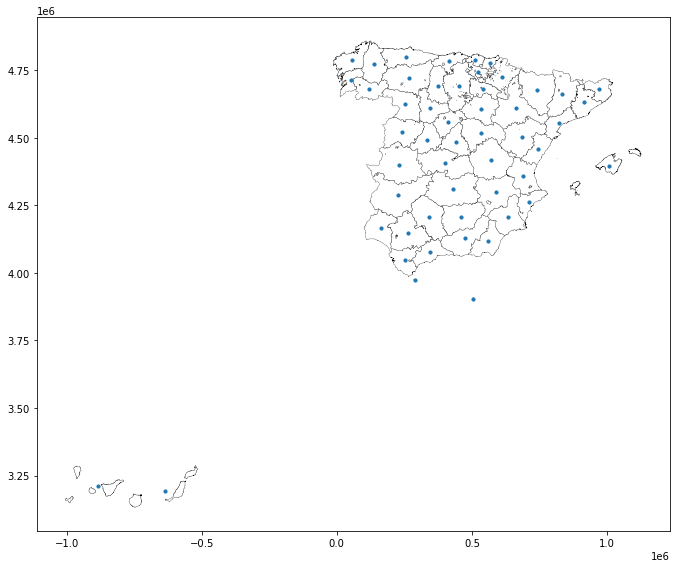

In [7]:
ax = gdf.plot(edgecolor='black', facecolor='white', figsize=(10, 8), linewidth=0.25)
gdf_points.plot(ax=ax, markersize=10)
plt.tight_layout()

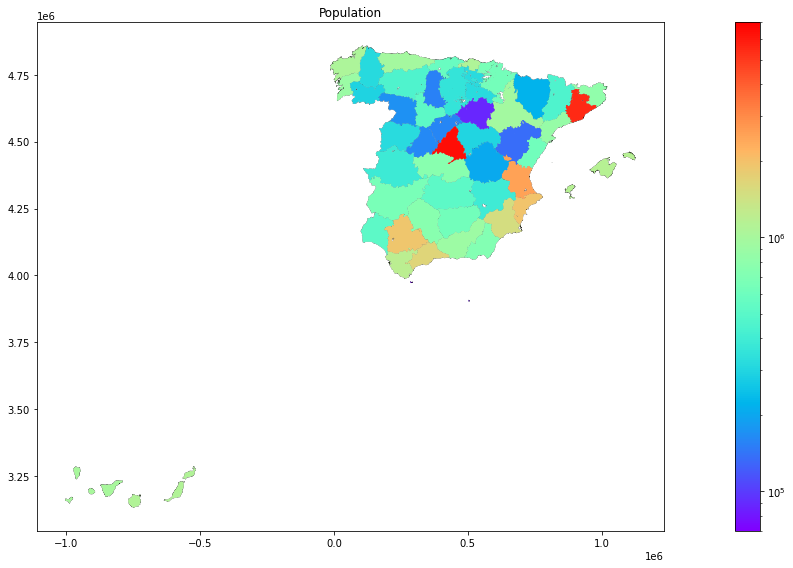

In [8]:
ax = gdf.plot(edgecolor='black', facecolor='white', figsize=(20, 8), linewidth=0.25)
ax.set_title("Population")
gdf.plot(ax=ax, column='POP', cmap='rainbow', legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=70_000, vmax=7_000_000))
gdf = gdf.to_crs(4326)
plt.tight_layout()
plt.savefig('Spain_pop.pdf', bbox_inches='tight')

## Preprocess of the data

In [10]:
def preprocess(path):
    dtypes = {"Origen":str,"Destino":str,"Año":str,"Mes":str,"Día":str,"Periodo":str,"Modo":str,"Distancia":str,"Residencia":str,"Actividad_Origen":str,"Actividad_Destino":str,
              "Viajeros":str,"Viajeros-km":str}
    df = pd.read_csv(path, encoding="utf-8", dtype=dtypes)
    df['Viajeros'] = df['Viajeros'].str.replace(r'\,','').astype(float)
    df['Viajeros-km'] = df['Viajeros-km'].str.replace(r'\,','').astype(float)
    df['Origen2'] = df['Origen'].apply(lambda z: z[:2])
    df['Destino2'] = df['Destino'].apply(lambda z: z[:2])
    return df

In [11]:
july_dfs = []
for n in [str(z).zfill(2) for z in range(0, 13)]:
     with open(f"../July/VI_J{n}.csv", 'r') as f:
        df = preprocess(f)
        df= df[['Origen2','Destino2','Viajeros']]
        july_dfs.append(df)

In [12]:
october_dfs = []
for n in [str(z).zfill(2) for z in range(0, 16)]:
     with open(f"../October/VI_O{n}.csv", 'r') as f:
        df = preprocess(f)
        df= df[['Origen2','Destino2','Viajeros']]
        october_dfs.append(df)

In [13]:
def get_dfs_weekday(dfs):
    df = pd.concat(dfs)
    df = df.groupby(['Origen2', 'Destino2']).Viajeros.sum().to_frame('Viajeros')
    df = df.reset_index(inplace=False)
    df.Viajeros = df.Viajeros / len(dfs)
    df.columns = ['oz', 'dz', 'actual_od']
    return df

In [14]:
dfs_weekday = [july_dfs[0], july_dfs[1], july_dfs[2], july_dfs[3],july_dfs[4], july_dfs[7], july_dfs[9],july_dfs[10], july_dfs[11]]
dfs_weekend = [july_dfs[5], july_dfs[6],july_dfs[8], july_dfs[12]]
july_weekday_df = get_dfs_weekday(dfs_weekday)
july_weekend_df = get_dfs_weekday(dfs_weekend)

In [15]:
dfs_weekday = [october_dfs[0], october_dfs[1], october_dfs[2], october_dfs[3],october_dfs[4], october_dfs[7], october_dfs[10],october_dfs[10], october_dfs[12],october_dfs[13]]
dfs_weekend = [october_dfs[5], october_dfs[6],october_dfs[8], october_dfs[9],october_dfs[14], october_dfs[15]]
october_weekday_df = get_dfs_weekday(dfs_weekday)
october_weekend_df = get_dfs_weekday(dfs_weekend)


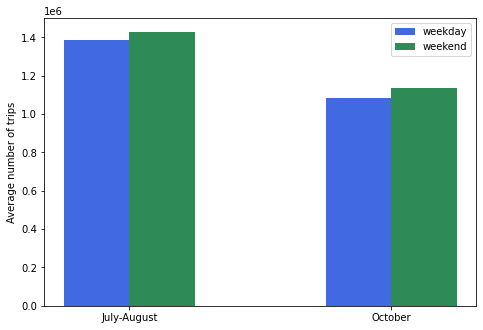

In [15]:
all_means_weekday =  [july_weekday_df.actual_od.mean(),october_weekday_df.actual_od.mean() ]
all_means_weekend = [july_weekend_df.actual_od.mean(),october_weekend_df.actual_od.mean()]
tic = ['July-August', 'October']
ind = np.arange(2)
width = 0.25
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(ind, all_means_weekday, width, color='royalblue')
rects2 = ax.bar(ind+width, all_means_weekend, width, color='seagreen')

ax.set_ylabel('Average number of trips')
ax.set_xticklabels( tic) 
ax.set_xticks(ind + width / 2)
#plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(labels=['weekday', 'weekend'])
plt.tight_layout()
#ax.set_ylim([0.8*10**6,1.5*10**6])
#plt.grid(True)

plt.savefig('s_average_trips.pdf', bbox_inches='tight')

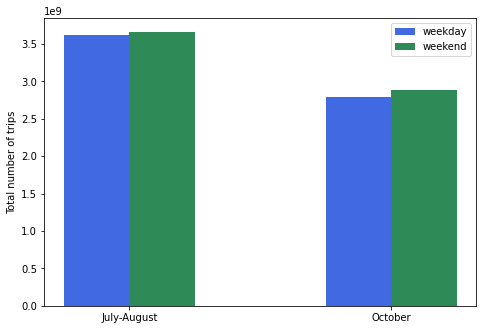

In [16]:
all_means_weekday =  [july_weekday_df.actual_od.sum(),october_weekday_df.actual_od.sum() ]
all_means_weekend = [july_weekend_df.actual_od.sum(),october_weekend_df.actual_od.sum()]
tic = ['July-August', 'October']
ind = np.arange(2)
width = 0.25
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(ind, all_means_weekday, width, color='royalblue')
rects2 = ax.bar(ind+width, all_means_weekend, width, color='seagreen')

ax.set_ylabel('Total number of trips')
ax.set_xticklabels( tic) 
ax.set_xticks(ind + width / 2)
#plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(labels=['weekday', 'weekend'])
plt.tight_layout()
#ax.set_ylim([2.5*10**9,3.8*10**9])
#plt.grid(True)

plt.savefig('s_sum_trips.pdf', bbox_inches='tight')

In [17]:
all_dfs =  [july_weekday_df,october_weekday_df,july_weekend_df,october_weekend_df]

In [18]:
def df_stastatics(df):
    min_data =  df.actual_od.min()
    max_data = df.actual_od.max()
    average = df.actual_od.mean()
    std_data = df.actual_od.std()
    total = df.actual_od.sum()
    return round(min_data,2),round(max_data,2), round(average,2), round(std_data,2), round(total,2)

In [19]:
for d in all_dfs:
    print(df_stastatics(d))

(13.11, 127040817.44, 1387501.91, 6638218.87, 3611667465.67)
(20.2, 115797330.0, 1082167.13, 5340608.4, 2785498191.5)
(32.5, 129634695.25, 1429523.33, 6847990.42, 3663868290.5)
(51.33, 104318326.5, 1136860.36, 5424096.08, 2888762167.83)


In [16]:
def get_destino_distribution(df,Origen):
    destino_distribution = df[df.oz == Origen].groupby('dz').actual_od.sum().to_frame('weight')
    destino_distribution.reset_index(inplace=True)
    df_all_destino = pd.DataFrame([str(z).zfill(2) for z in range(1, 53)], columns=['dz'])
    destino_distribution = destino_distribution.merge(df_all_destino, on='dz', how='outer')
    destino_distribution.weight.fillna(0, inplace=True)
    destino_distribution['norm_od'] = destino_distribution['weight'] / destino_distribution['weight'].sum()
    destino_distribution.sort_values('norm_od', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

    return destino_distribution

In [17]:
def plot_signiture_selected_cities(df,df1,scale = None):
    plt.figure(figsize=(14, 5))   
    destino_distributions = {}
    destino_norm_distributions = {}
    selected_cities = { '28': 'Madrid','08': 'Barcelona', '03': 'Alicante', '35': 'Palmas Las' ,'50': 'Zaragoza','51': 'Ceuta'}
    for code,name in selected_cities.items():
        destino_distributions[code] = get_destino_distribution(df,Origen=code)
        destino_norm_distributions[code] = destino_distributions[code].norm_od
        
    rank = list(range(1, 53))
    plt.subplot(1, 2, 1)
    for code,name in selected_cities.items():
        destino_distribution = destino_distributions[code]
        plt.plot(rank, destino_distribution.norm_od, '-', alpha=0.75,label = name)
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    if scale == 'log':
            plt.yscale('log')
            #plt.ylim([-0.1, 1.1])
    plt.title('Mobility signiture on weekday in July-August')
    plt.legend()
    plt.tight_layout()
       
    destino_distributions1 = {}
    destino_norm_distributions1 = {}
    selected_cities = { '28': 'Madrid','08': 'Barcelona', '03': 'Alicante', '35': 'Palmas Las' ,'50': 'Zaragoza','51': 'Ceuta'}
    for code,name in selected_cities.items():
        destino_distributions1[code] = get_destino_distribution(df1,Origen=code)
        destino_norm_distributions1[code] = destino_distributions1[code].norm_od
        
    rank = list(range(1, 53))
    plt.subplot(1, 2, 2)
    for code,name in selected_cities.items():
        destino_distribution1 = destino_distributions1[code]
        plt.plot(rank, destino_distribution1.norm_od, '-', alpha=0.75,label = name)
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    if scale == 'log':
            plt.yscale('log')
            #plt.ylim([-0.1, 1.1])
    plt.title('Mobility signiture on weekday in October')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/s_select_citis.pdf', bbox_inches='tight')

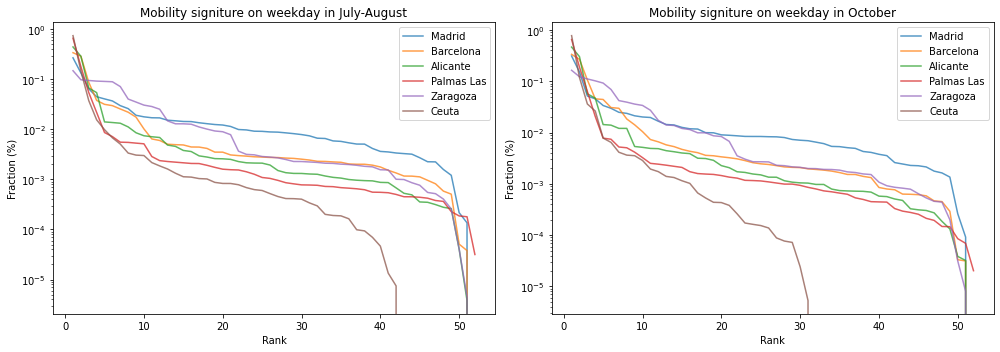

In [22]:
df =july_weekday_df
df1 = october_weekday_df
plot_signiture_selected_cities(df,df1,scale = 'log')

In [23]:
def plot_compare_all_signature_oneplot(city_name,code):   
    plt.figure(figsize=(8,4))
    plt.suptitle(r"$\bf{" + str(city_name)+ "}$", fontsize=16)
    plt.subplot(1, 2, 1)
    
    rank = list(range(1, 53))
    
    destino_distributions1 = {}
    destino_norm_distributions1 = {}
    df1 = july_weekday_df
    df2 = october_weekday_df
    
    
       
    destino_distributions1 = get_destino_distribution(df1,Origen=code)
    destino_norm_distributions1 = destino_distributions1.norm_od
    
    destino_distributions2 = get_destino_distribution(df2,Origen=code)
    destino_norm_distributions2 = destino_distributions2.norm_od


    plt.plot(rank, destino_norm_distributions1, '-.', color = 'b',label = 'July-August', alpha = 0.5)
    plt.plot(rank, destino_norm_distributions2, color = 'b',label = 'July-August', alpha = 0.5)

    plt.xlabel('Rank')
    plt.ylabel('Fraction  (%)')
    plt.yscale('log')        
    plt.title('Weekday', fontsize=16)
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(1, 2, 2)
    df1 = july_weekend_df
    df2 =  october_weekend_df    
    destino_distributions1 = get_destino_distribution(df1,Origen=code)
    destino_norm_distributions1 = destino_distributions1.norm_od
    
    destino_distributions2 = get_destino_distribution(df2,Origen=code)
    destino_norm_distributions2 = destino_distributions2.norm_od
    plt.plot(rank, destino_norm_distributions1, '-.', color = 'BlueViolet',label = 'July-August', alpha = 0.5)
    plt.plot(rank, destino_norm_distributions2,color = 'BlueViolet',label = 'October', alpha = 0.5)
    plt.yscale('log')   
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    plt.legend()
    plt.title('Weekend', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'plots/s_{city_name}_signiture.pdf', bbox_inches='tight')


In [24]:
def plot_compare_all_signature_oneplot_notscalled(city_name,code):   
    plt.figure(figsize=(8,4))
    plt.suptitle(r"$\bf{" + str(city_name)+ "}$", fontsize=16)
    plt.subplot(1, 2, 1)
    
    rank = list(range(1, 53))
    
    destino_distributions1 = {}
    destino_norm_distributions1 = {}
    df1 = july_weekday_df
    df2 = october_weekday_df
    
    
       
    destino_distributions1 = get_destino_distribution(df1,Origen=code)
    destino_norm_distributions1 = destino_distributions1.weight
    
    destino_distributions2 = get_destino_distribution(df2,Origen=code)
    destino_norm_distributions2 = destino_distributions2.weight


    plt.plot(rank, destino_norm_distributions1, '-.', color = 'b',label = 'July-August', alpha = 0.5)
    plt.plot(rank, destino_norm_distributions2, color = 'b',label = 'July-August', alpha = 0.5)

    plt.xlabel('Rank')
    plt.ylabel('Number of commuter')
    plt.yscale('log')        
    plt.title('Weekday', fontsize=16)
    plt.legend()
    plt.tight_layout()
    
    
    plt.subplot(1, 2, 2)
    df1 = july_weekend_df
    df2 =  october_weekend_df    
    destino_distributions1 = get_destino_distribution(df1,Origen=code)
    destino_norm_distributions1 = destino_distributions1.weight    
    destino_distributions2 = get_destino_distribution(df2,Origen=code)
    destino_norm_distributions2 = destino_distributions2.weight
    plt.plot(rank, destino_norm_distributions1, '-.', color = 'BlueViolet',label = 'July-August', alpha = 0.5)
    plt.plot(rank, destino_norm_distributions2,color = 'BlueViolet',label = 'October', alpha = 0.5)
    plt.yscale('log')   
    plt.xlabel('Rank')
    plt.ylabel('Number of commuter')
    plt.legend()
    plt.title('Weekend', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'plots/s_{city_name}_signiture_notscalled.pdf', bbox_inches='tight')


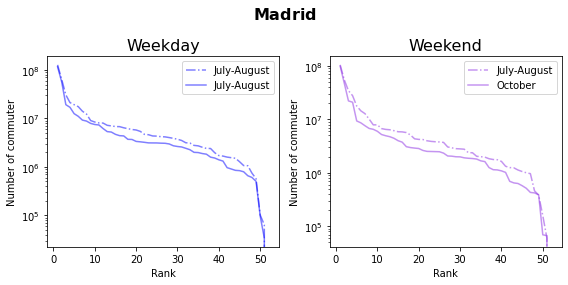

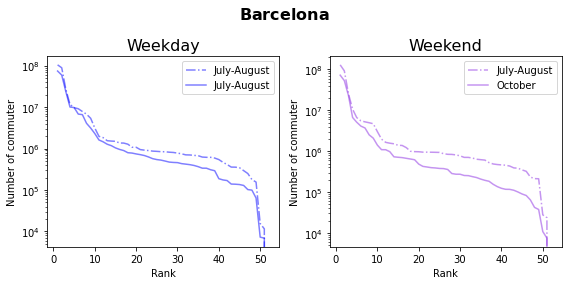

In [25]:
plot_compare_all_signature_oneplot_notscalled('Madrid','28')
plot_compare_all_signature_oneplot_notscalled('Barcelona', '08')
#plot_compare_all_signature_oneplot_notscalled('Araba','01')
#plot_compare_all_signature_oneplot_notscalled('Las Palmas','35')


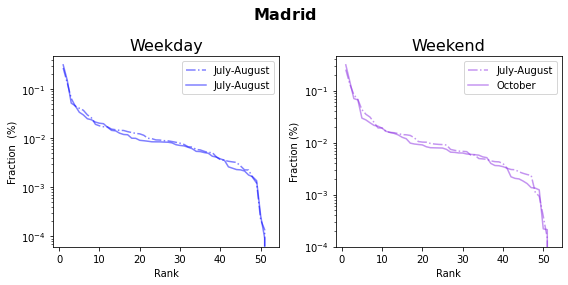

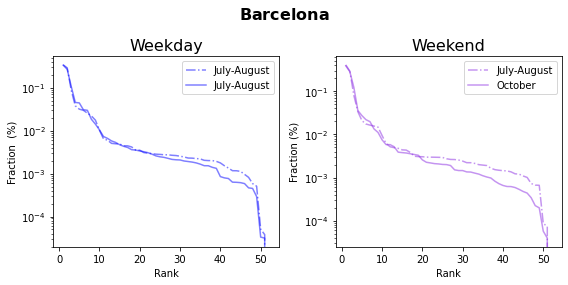

In [26]:
plot_compare_all_signature_oneplot('Madrid','28')
plot_compare_all_signature_oneplot('Barcelona', '08')
#plot_compare_all_signature_oneplot('Ceuta','51')
#plot_compare_all_signature_oneplot('Araba','01')
#plot_compare_all_signature_oneplot('Las Palmas','35')


In [18]:
def plot_signiture(df,title,scale = None):
    plt.figure()
    rank = list(range(1, 53))
    destino_distributions = {}
    destino_norm_distributions = {}
    for i in range(1, 53):
        origen = str(i).zfill(2)
        destino_distributions[origen] = get_destino_distribution(df,Origen=origen)
        destino_norm_distributions[origen] = destino_distributions[origen].norm_weight

    plt.subplot(1, 1, 1)
    for i in range(1, 53):
        destino_distribution = destino_distributions[str(i).zfill(2)]
        plt.plot(rank, destino_distribution.norm_weight, color='blue', alpha=0.5)
    plt.xlabel('Rank')
    plt.ylabel('Fraction')
    if scale == 'log':
            plt.yscale('log')
            #plt.ylim([-0.1, 1.1])
    plt.title(f'Mobility signiture for {title}')
    plt.tight_layout()

In [19]:
def get_distance_matrix(df):
    destino_distributions = {}
    destino_norm_distributions = {}
    for i in range(1, 53):
        origen = str(i).zfill(2)
        destino_distributions[origen] = get_destino_distribution(df, Origen=origen)
        destino_norm_distributions[origen] = destino_distributions[origen].norm_od
    
    dist_mat = []
    destino_dist_avg = {}
    for i in range(1, 53):
        origen_i = str(i).zfill(2)
        array_i = []
        for j in range(1, 53):
            origen_j = str(j).zfill(2)
            array_i.append(jensenshannon(destino_norm_distributions[origen_i], 
                                         destino_norm_distributions[origen_j], 
                                         base=2))
        dist_mat.append(array_i)
        array_i = np.array(array_i)
        destino_dist_avg[origen_i] = np.nanmean(array_i)
    return dist_mat

In [20]:
def plot_distance_matrix(dist_mat):
    plt.figure(figsize=(14, 14))
    plt.imshow(dist_mat, cmap='Spectral')
    plt.colorbar()
    plt.xticks(range(52), [dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], rotation=90)
    plt.yticks(range(52), [dict_ine_name[str(i).zfill(2)] for i in range(1, 53)])
    plt.title('distance matrix')

In [21]:
sort_by_pop = df_pop.sort_values('POP', ascending=False).CPRO.values.tolist()

In [22]:
def get_distance_matrix_ordered(df_truth, ordered):
    destino_distributions = {}
    destino_norm_distributions = {}
    for i in range(1, 53):
        code = str(i).zfill(2)
        destino_distributions[code] = get_destino_distribution(df_truth,Origen=code)
        destino_norm_distributions[code] = destino_distributions[code].norm_od
        
    dist_mat = []
    destino_dist_avg = {}
    for origen_i in ordered:
        array_i = []
        for origen_j in ordered:
            array_i.append(jensenshannon(destino_norm_distributions[origen_i], 
                                         destino_norm_distributions[origen_j], 
                                         base=2))
        dist_mat.append(array_i)
        array_i = np.array(array_i)
        destino_dist_avg[origen_i] = np.nanmean(array_i)
    dist_mat = np.nan_to_num(dist_mat, nan=0) 
    return dist_mat

In [23]:
def plot_distance_matrix_ordered(dist_mat, ordered, title, size):
    plt.figure(figsize=size)
    plt.imshow(dist_mat, cmap='Spectral')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xticks(range(0,len(ordered)), [dict_ine_name[code] for code in ordered], rotation=90)
    plt.yticks(range(0,len(ordered)), [dict_ine_name[code] for code in ordered])
    plt.title(title)
    plt.tight_layout()   
    plt.savefig(f's_pop_sorted_{title}.pdf',bbox_inches='tight' )

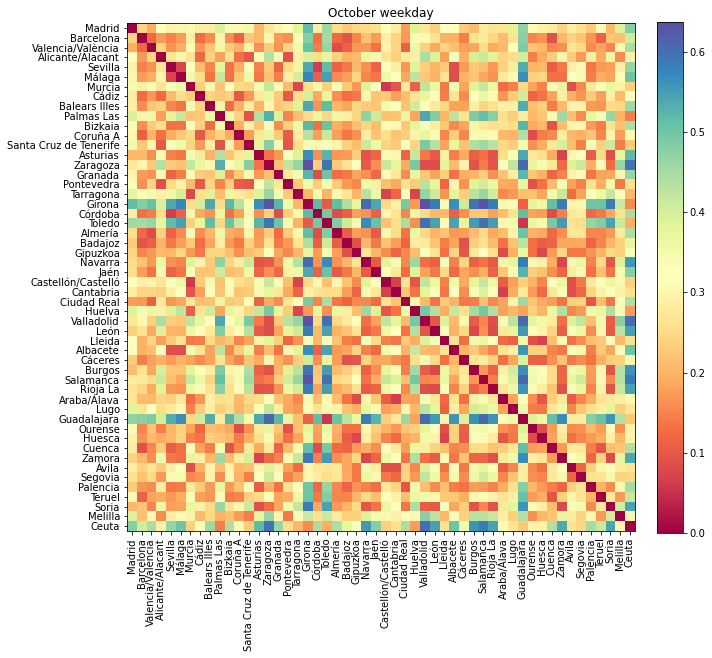

In [142]:
title_name ='October weekday'

plot_distance_matrix_ordered(get_distance_matrix_ordered(all_dfs[1], sort_by_pop), sort_by_pop, title_name, (10,10))

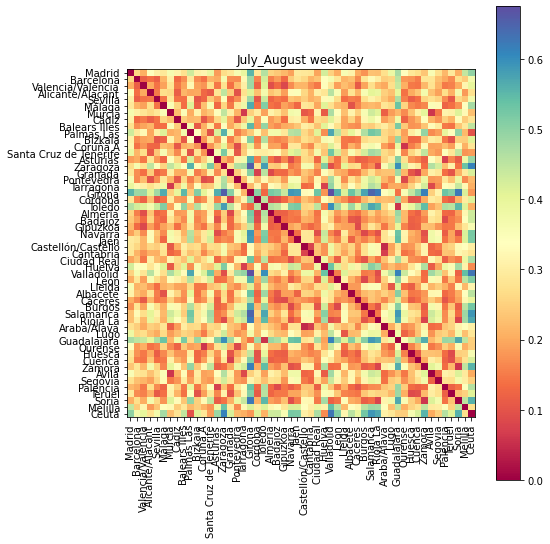

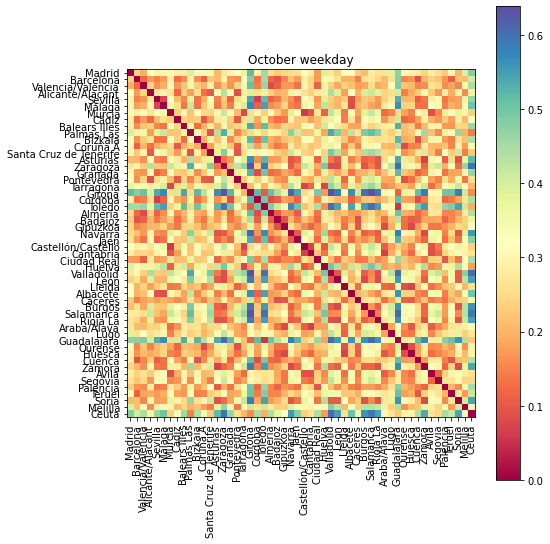

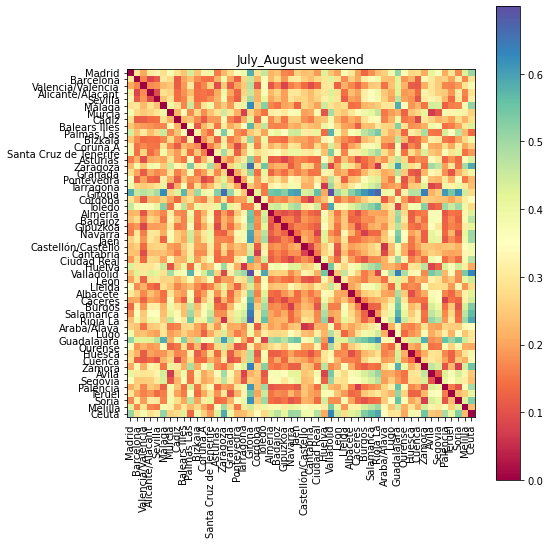

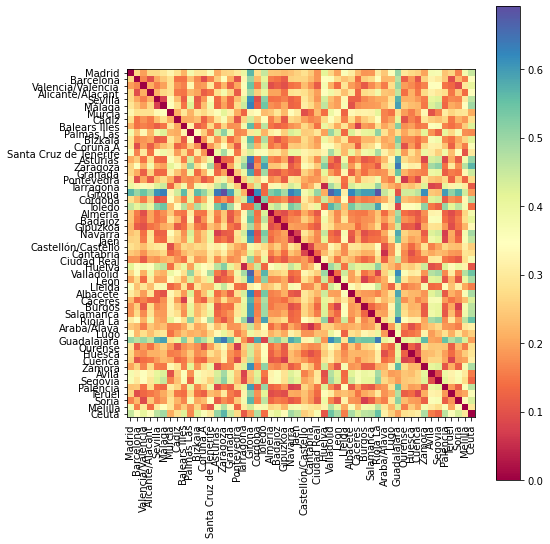

In [33]:
titles = ['July_August weekday','October weekday','July_August weekend','October weekend']
size = (8,8)

for df,title_name in zip(all_dfs,titles): 
    plot_distance_matrix_ordered(get_distance_matrix_ordered(df, sort_by_pop), sort_by_pop, title_name, size)

In [41]:
def plot_dendrogram(dist_mat, thr,linkage_method, noplot = False):
    colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    hierarchy.set_link_color_palette(colors)
    x = linkage(dist_mat,linkage_method)
    if noplot:
        return dendrogram(x, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], no_plot = True, leaf_rotation=90, above_threshold_color='b',color_threshold = thr,leaf_font_size =14)
    else: 
        plt.figure(figsize=(12, 6))
        g = dendrogram(x, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], leaf_rotation=90, above_threshold_color='b',color_threshold = thr,leaf_font_size =14)
        plt.axhline(y=thr, ls=':', color='k')
        plt.ylabel("Distance")
        plt.title(f'{linkage_method}')
        plt.tight_layout()

       # plt.savefig(f"{linkage_method}.pdf")
        return g

In [42]:
def plot_clustered_cities(group, title_name, annotate = False):
    #colors = np.unique(group['leaves_color_list']).tolist()
    colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]

    group_coord = {}
    for color in color_city_group_dict.keys():
        cities = color_city_group_dict[color]
        group_coord[color] = [list(dict_ine_name.keys())[list(dict_ine_name.values()).index(city)] for city in cities]   
    
    gdf = gpd.read_file('../Map/Provinces.shp', encoding='utf-8') 
    gdf_points = gdf.copy()
    gdf_points['geometry'] = gdf_points['geometry'].centroid
    gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'\,','')
    gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Alicante', r'Alicante/Alacant')
    gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Valencia/Valéncia', r'Valencia/València')
    gdf_points['lon'] = gdf_points.geometry.apply(lambda z: z.coords[0][0])
    gdf_points['lat'] = gdf_points.geometry.apply(lambda z: z.coords[0][1])
    gdf_points = gdf_points.merge(df_pop[['CPRO', 'POP']], on=['CPRO'])
    gdf_points = gdf_points.merge(df_GDP[['CPRO', 'GDP']], on=['CPRO'])
    gdf = gdf.merge(df_pop[['CPRO', 'POP']], on=['CPRO'])
    gdf = gdf.merge(df_GDP[['CPRO', 'GDP']], on=['CPRO'])
    
    
    
    ax = gdf.plot(facecolor='white', edgecolor='black', figsize=(10,8),linewidth=0.25)
    ax.set_title(title_name)
    for color,coord in group_coord.items() :
        #gdf_points[gdf_points.CPRO.isin(coord)].plot(ax=ax, color=color, legend=True)
        gdf[gdf.CPRO.isin(coord)].plot(ax=ax, color=color, alpha=0.5, legend=True)
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

    if annotate :    
        for x, y, label in zip(gdf_points.lon,gdf_points.lat, gdf_points.CPRO):
            ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

    plt.savefig(f's_{title_name}_clustered_map.pdf', bbox_inches='tight')


In [43]:
def plot_groups(group,df,scale = None):
    group_avg = []
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]
    unique_colors = np.unique(group['leaves_color_list']).tolist()
    num_cluster = len(unique_colors)
    plt.figure(figsize=(5 * num_cluster, 5))  
    for i ,select_group in enumerate(color_city_group_dict.values()):
        plt.subplot(1, num_cluster, i+1)
        arr_avg = np.array([0.0] * 52)
        for name in select_group:
            ine = dict_name_ine[name]
            distribution = get_destino_distribution(df, ine)
            rank = list(range(1, 53))
            plt.bar(rank,distribution.norm_od.tolist(), color=unique_colors[i], alpha=1/len(select_group))
            arr_avg += distribution.norm_od.tolist()
        arr_avg /= len(select_group)

        group_avg.append(arr_avg)
        plt.plot(rank,arr_avg, color='black', ls='--',linewidth=6)
        if scale == 'log':
            plt.yscale('log')
            plt.ylim([0.00001, 1.1])

        plt.xlabel('Rank')
        plt.ylabel('Fraction')
        plt.xlim([-1, 53])
        plt.title('Cluster %d' % (i+1))
        plt.tight_layout()
        plt.savefig('s_cluster_weekend.pdf', bbox_inches='tight')
    return group_avg

In [44]:
def plot_average_clusters(group,group_avg, scale = None):    
    plt.figure(figsize=(5, 5))
    rank = list(range(1, 53))
    unique_colors = np.unique(group['leaves_color_list']).tolist()

    for i in range(len(group_avg)):
        plt.plot(rank, group_avg[i], color=unique_colors[i], ls='-', label='group %d' % (i+1))
        plt.legend()
        plt.xlabel('Rank')
        plt.ylabel('Fraction')
        plt.title('Average of groups')
        plt.xlim([-1, 53])
        if scale == 'log':
            plt.yscale('log')
        plt.tight_layout()


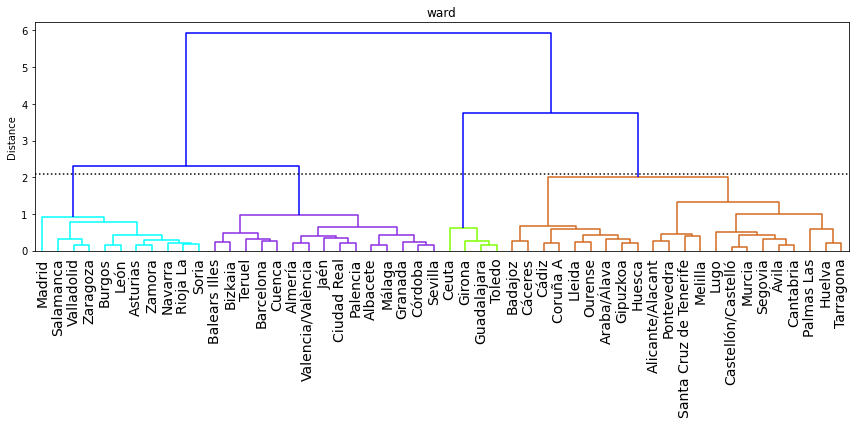

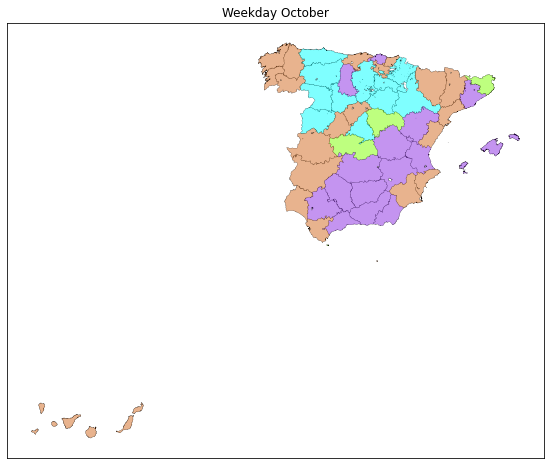

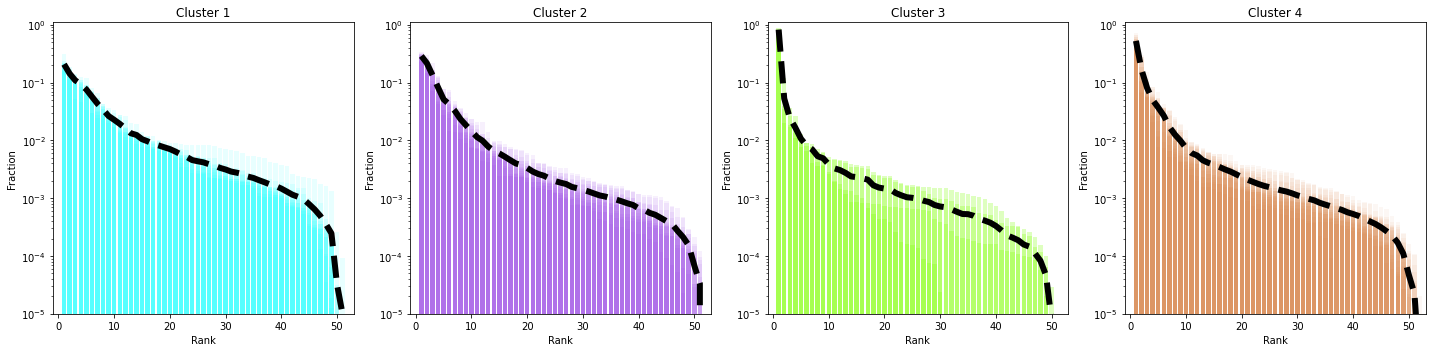

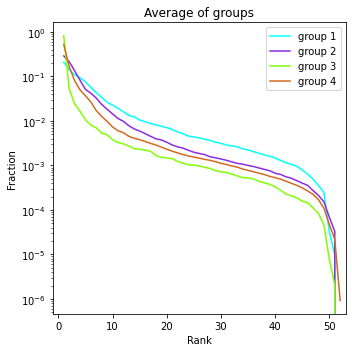

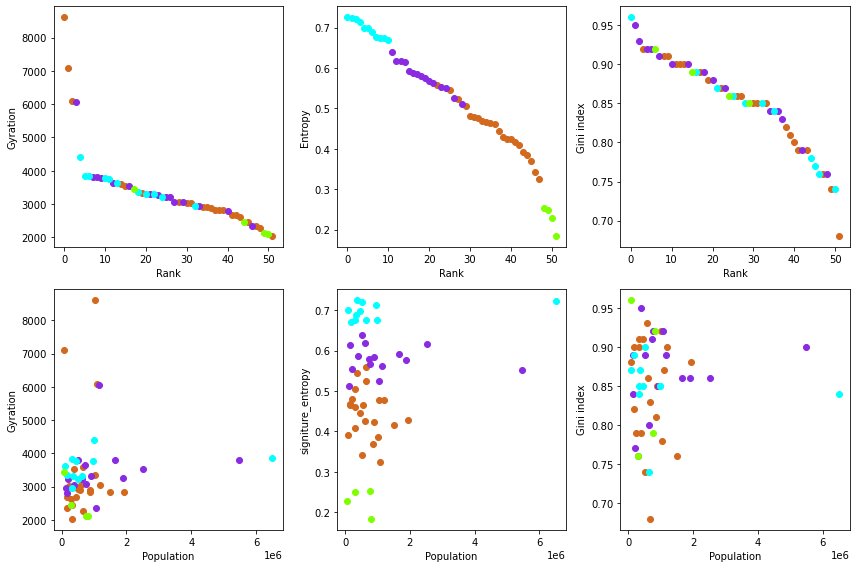

In [127]:
dist_mat = get_distance_matrix(october_weekday_df)
linkage_method = 'ward'
thr = 2.1    
title_name = 'Weekday October'
group = plot_dendrogram(dist_mat, thr,linkage_method, noplot = False)
plot_clustered_cities(group, title_name, annotate = False)
group_avg = plot_groups(group,df,scale = 'log')
plot_average_clusters(group,group_avg, scale = 'log')
df = october_weekday_df
mobility_network = get_mobility_network(df)
results = get_gyration(mobility_network)
gdf_points = get_gdf_points(results, df)
plt_ranked_entropy_gyration(group, gdf_points)

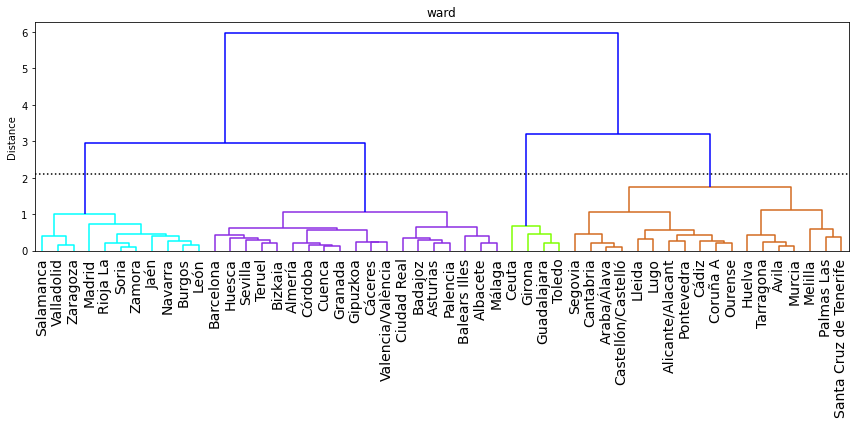

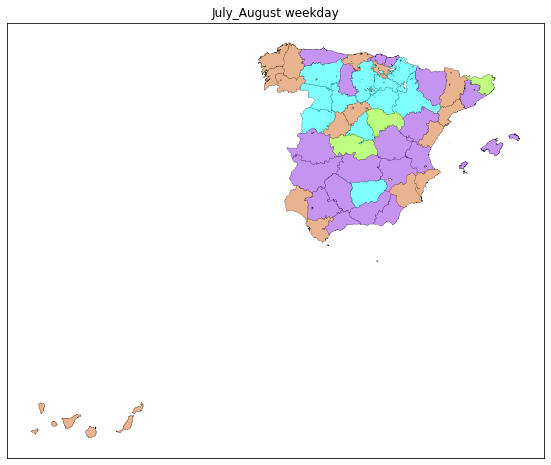

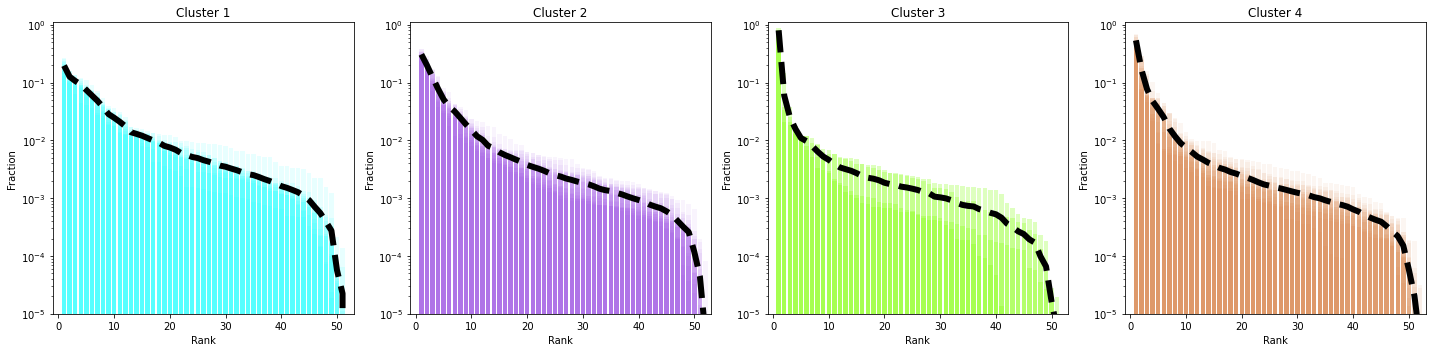

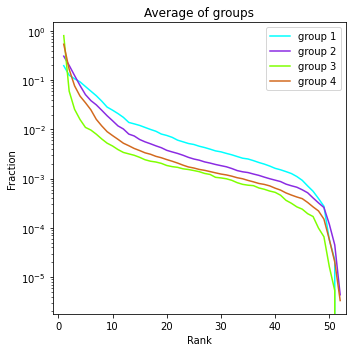

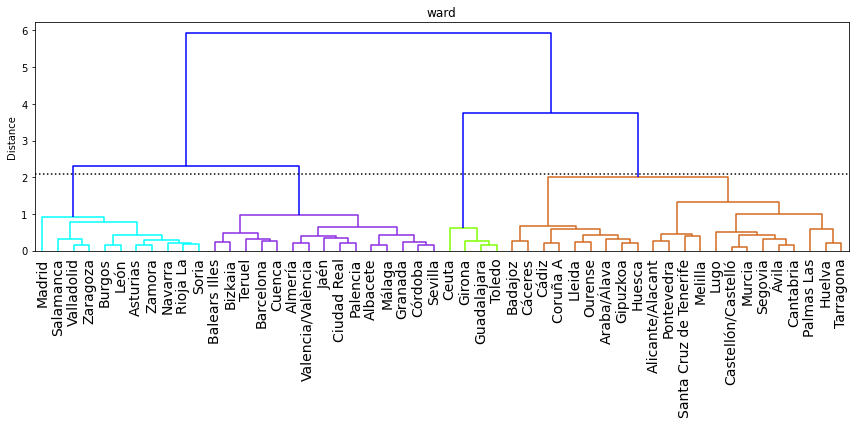

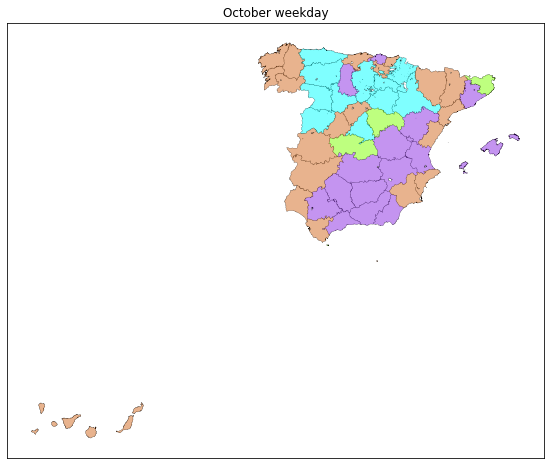

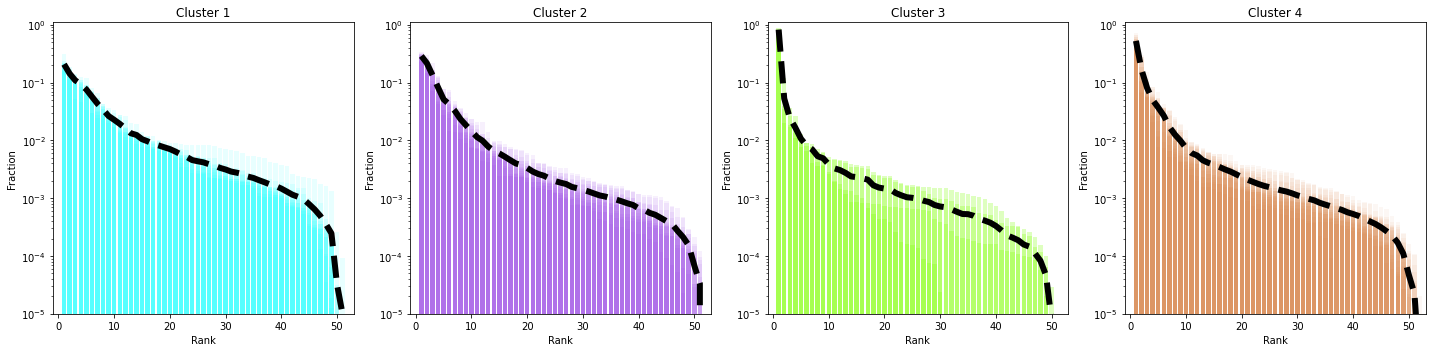

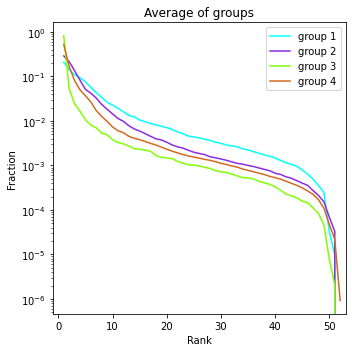

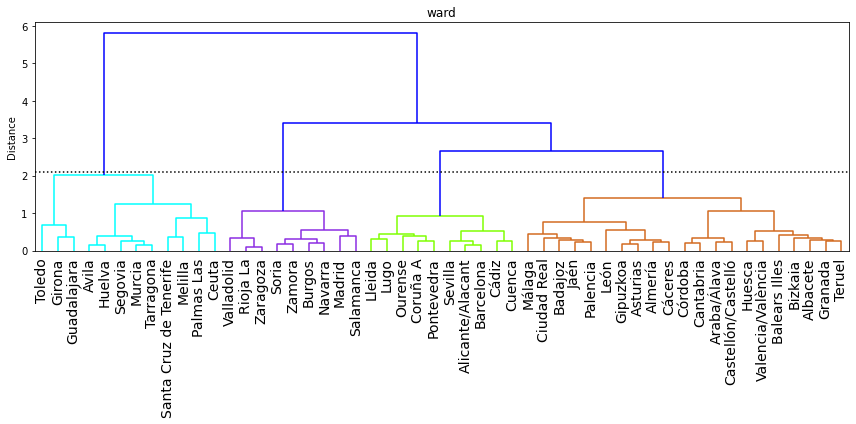

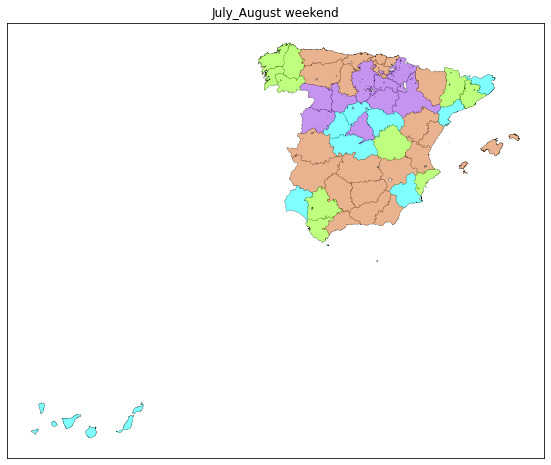

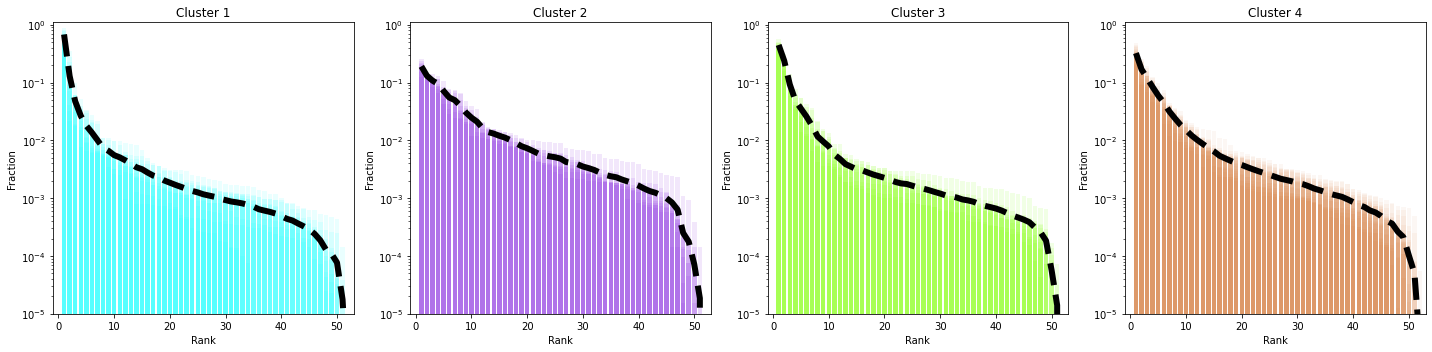

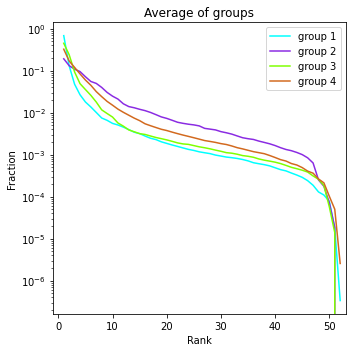

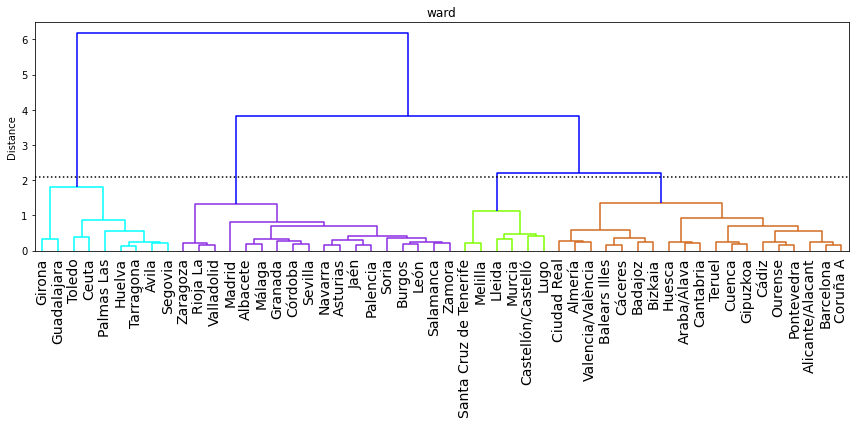

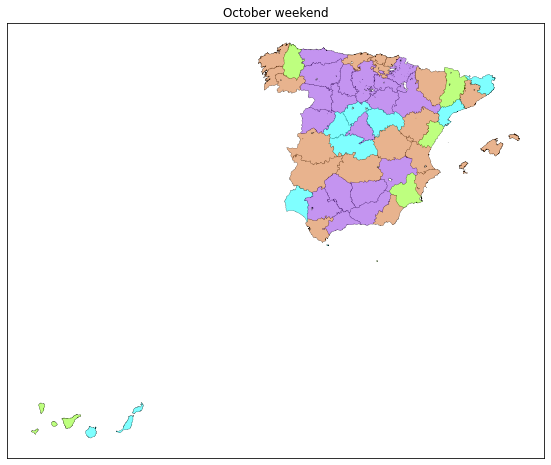

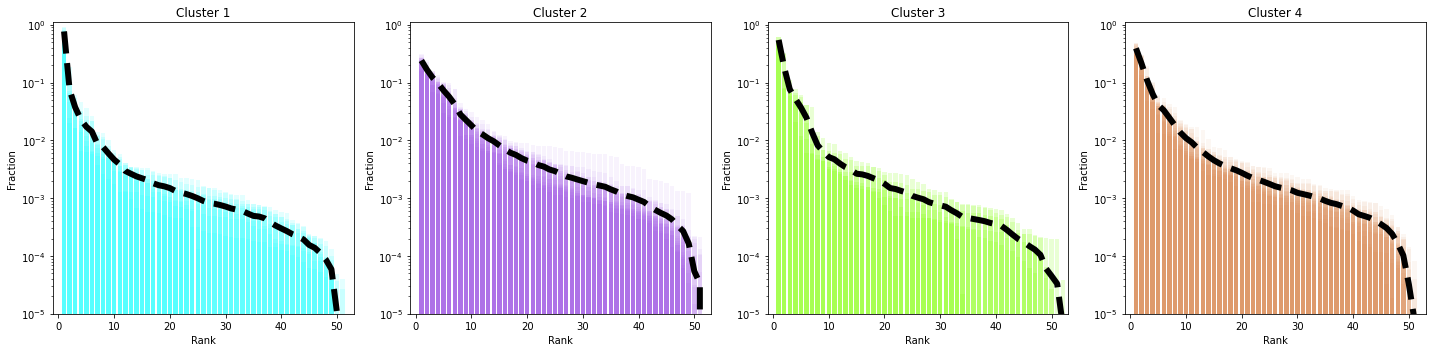

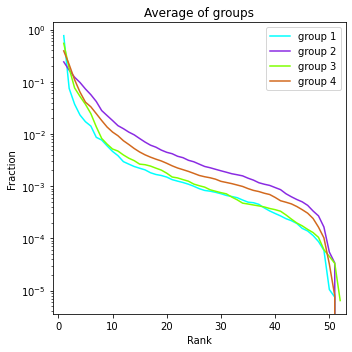

In [123]:
titles = ['July_August weekday','October weekday','July_August weekend','October weekend']
groups = []
groups_ave = []

for df,title_name in zip(all_dfs,titles): 
    dist_mat = get_distance_matrix(df)
    linkage_method = 'ward'
    thr = 2.1    
    group = plot_dendrogram(dist_mat, thr,linkage_method, noplot = False)
    groups.append(group)
    plot_clustered_cities(group, title_name, annotate = False)
    group_avg = plot_groups(group,df,scale = 'log')
    groups_ave.append(group_avg)
    plot_average_clusters(group,group_avg, scale = 'log')

In [39]:
def get_calinski_dict(dist_mat): 
    calinski_dict = {}
    linkage_methods = ['single' ,'complete' ,'average','weighted','centroid','median','ward']
    thresholds = np.linspace(0.6,2.1,7)
    for linkage_method in linkage_methods:
        thr_dict = {}
        for thr in thresholds:
            group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
            labels=group['leaves_color_list']
            if (len(np.unique(group['leaves_color_list'])) > 3):
                dict_temp = {}
                dict_temp["Number of clusters: "] = len(np.unique(group['leaves_color_list']).tolist())
                dict_temp ["Calinski-Harabasz Index: "] = round(skm.calinski_harabasz_score(dist_mat, labels=labels),2)
                thr_dict[thr] =  dict_temp
            else :
                   break
        calinski_dict[linkage_method] = thr_dict

    return calinski_dict

In [40]:
def plot_CalinskiIndex(calinski_dict, noplot = False):
    best_values = {}
    for inkm,data in calinski_dict.items():
        if len(data)>1:
            temp_list = []
            for thr, v in data.items():
                if v['Number of clusters: '] < 8:
                    temp_list.append((thr,v['Calinski-Harabasz Index: ']))
            if noplot == False :
                x, y = zip(*temp_list) 
                plt.plot(x, y,'-s', label = inkm)
                max_y = max(y)
                index = y.index(max_y)
                cln = np.squeeze([v['Number of clusters: ']for thr, v in data.items() if thr == x[index]])
                plt.text(x[index],max_y,f'#clusters: {cln}',ha='center')
                #plt.plot(x[index],max_y,'*')
                plt.legend()
                plt.xlabel('Thresholds')
                plt.ylabel('Calinski-Harabasz Index')
                #plt.title('Thresholds')
                plt.grid(True)
                plt.tight_layout()
                best_values[inkm]= (x[index],max_y)
                
            else:
                x, y = zip(*temp_list) 
                max_y = max(y)
                index = y.index(max_y)
                best_values[inkm]= (x[index],max_y)
    plt.show()
    return best_values

In [41]:
def clustering_methods_statastics(best_values_all):
    cluster_methods = []
    for i in range(0, 7):
        cluster_methods.append([k for k,v in best_values_all[i].items() if v == max(best_values_all[i].values(), key=lambda x:x[1])])
        clusters_names, frequencies = [], []
    for each_cluster in cluster_methods:
        if not(each_cluster in frequencies):
            frequencies = frequencies + [each_cluster]
            clusters_names = clusters_names + [[each_cluster, 1]]
        else:
            for index in range(len(clusters_names)):
                if clusters_names[index][0] == each_cluster:
                    clusters_names[index][1] = clusters_names[index][1]+1

    for each in clusters_names:
        print ('{} : {}'.format(*each))

In [42]:
def clustering_methods_statastics(best_values_all):
    cluster_methods = []
    for i in range(0, 4):
        cluster_methods.append([k for k,v in best_values_all[i].items() if v == max(best_values_all[i].values(), key=lambda x:x[1])])
        clusters_names, frequencies = [], []
    for each_cluster in cluster_methods:
        if not(each_cluster in frequencies):
            frequencies = frequencies + [each_cluster]
            clusters_names = clusters_names + [[each_cluster, 1]]
        else:
            for index in range(len(clusters_names)):
                if clusters_names[index][0] == each_cluster:
                    clusters_names[index][1] = clusters_names[index][1]+1

    for each in clusters_names:
        print ('{} : {}'.format(*each))

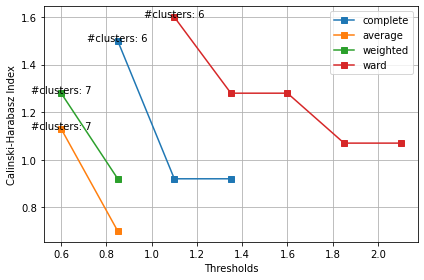

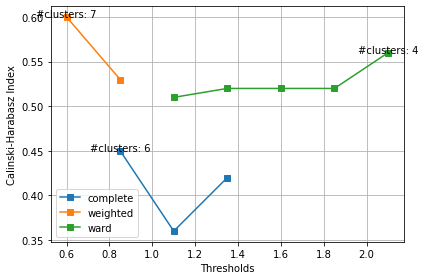

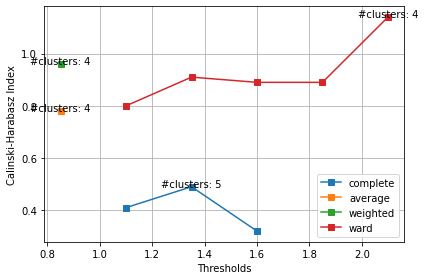

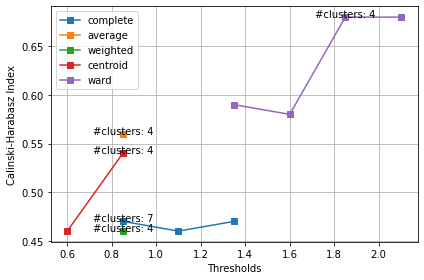

In [43]:
best_values_all = []

for df in all_dfs:
    dist_mat = get_distance_matrix(df)
    calinski_dict = get_calinski_dict(dist_mat)
    best_values = plot_CalinskiIndex(calinski_dict)
    best_values_all.append(best_values)

In [44]:
clustering_methods_statastics(best_values_all)

['ward'] : 3
['weighted'] : 1


In [24]:
def get_mobility_network(df):
    dict_lon = dict(zip(gdf_points.CPRO, gdf_points.lon))
    dict_lat = dict(zip(gdf_points.CPRO, gdf_points.lat))
    mobility_network = df.groupby(['oz', 'dz', ]).actual_od.sum().to_frame('flow')
    mobility_network.reset_index(inplace=True)
    mobility_network['norm_flow'] = mobility_network.apply(lambda z: z.flow / mobility_network[mobility_network.oz == z.oz].flow.sum(), axis=1)
    mobility_network['Origen_lon'] = mobility_network.oz.map(dict_lon)
    mobility_network['Origen_lat'] = mobility_network.oz.map(dict_lat)
    mobility_network['Destino_lon'] = mobility_network.dz.map(dict_lon)
    mobility_network['Destino_lat'] = mobility_network.dz.map(dict_lat)
    mobility_network['geometry'] = mobility_network.apply(lambda z: LineString([[z.Origen_lon, z.Origen_lat], [z.Destino_lon, z.Destino_lat]]), axis=1)
    mobility_network = gpd.GeoDataFrame(mobility_network, geometry='geometry')
    mobility_network['length'] = mobility_network.geometry.length / 1000
    return mobility_network

In [26]:
def get_gyration(mobility_network):
    results = []
    for Origen in mobility_network.oz.unique():
        select = mobility_network[mobility_network.oz == Origen].copy(True)
        results.append([Origen, (select.flow * select.length).mean(), (select.flow * select.length).mean()/select.flow.mean()])
    return results

In [48]:
def plot_network(mobility_network):
    fig = plt.figure(figsize=(8,10))
    ax = fig.add_subplot(1, 1, 1)

    dict_lon = dict(zip(gdf_points.CPRO, gdf_points.lon))
    dict_lat = dict(zip(gdf_points.CPRO, gdf_points.lat))
    
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]

    g = nx.from_pandas_edgelist(mobility_network, 'Origen2', 'Destino2', ['flow', 'norm_flow'])
    pos = {x: (dict_lon.get(x, 0) , dict_lat.get(x, 0)) for x in set(dict_lat).union(dict_lon)}
    g.add_nodes_from(list(pos.keys()))
    nx.set_node_attributes(g, pos, 'coord')
    node_color = {}
    for idx,name in dict_ine_name.items():
        for k,v in color_city_group_dict.items():
            for i in range(len(v)):
                if v[i] == name:
                    node_color[idx] = k 
    nx.draw_networkx_nodes(g, pos = nx.get_node_attributes(g , 'coord'), ax = ax,node_size=300, node_color=node_color.values(), cmap=plt.cm.tab10)

    edgelist = [(u, v) for (u, v, d) in g.edges(data=True)]
    # edges
   # nx.draw_networkx_edges(g, pos, ax = ax,edgelist=edgelist, 
   #                        width=1, alpha=0.5, edge_color='grey')
    durations = [i['norm_flow']*10 for i in dict(g.edges).values()]
    nx.draw_networkx_edges(g, pos, ax = ax,edgelist=edgelist, 
                       width=durations,  edge_color='k')

    # labels
    nx.draw_networkx_labels(g, pos, ax = ax,font_size=12, font_family='Arial')

    plt.gca()
    ax.margins(0.08)
    plt.axis('off')
    plt.tight_layout()
    return g

In [131]:
def get_similarity_matrix(all_dfs):
    all_labels = []
    linkage_method = 'ward'
    thr = 2.1    
    for df in all_dfs:
            dist_mat = get_distance_matrix(df)
            group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
            labels=group['leaves_color_list']
            all_labels.append(labels)
    ARIs = [] 
    for row in all_labels:
        ARI = []
        for row2 in all_labels:
            ARI.append(round(skm.adjusted_rand_score(row,row2),2))
        ARIs.append(ARI)
    return ARIs

In [132]:
def plot_similarity_matrix(ARIs,titles):
    plt.figure()
    plt.imshow(ARIs, cmap='Spectral')
    plt.colorbar()
    plt.xticks(range(4),[titles[i] for i in range(0, 4)], rotation=90)
    plt.yticks(range(4),[titles[i] for i in range(0, 4)])
    plt.title('Similaity matrix')

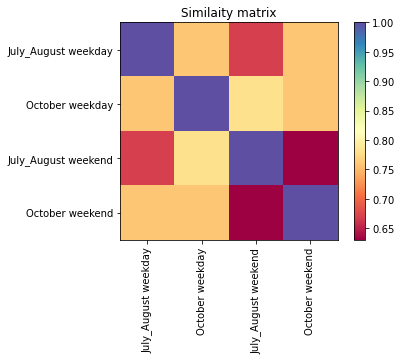

In [133]:
titles = ['July_August weekday','October weekday','July_August weekend','October weekend']
ARIs = get_similarity_matrix(all_dfs)
plot_similarity_matrix(ARIs,titles)

In [27]:
def cal_signiture_entropy(df, CPRO):
    df['norm_od'] = df['actual_od'] / df['actual_od'].sum()
    df.sort_values('norm_od', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df_signiture = get_destino_distribution(df, str(CPRO))
    return entropy(df_signiture.norm_od)/np.log(len(df_signiture.norm_od))

In [28]:
def gini_coefficient(x):
#A Gini coefficient of zero expresses perfect equality, where all values are the same (for example, where everyone has the same income).
#A Gini coefficient of one (or 100%) expresses maximal inequality among values (.g., for a large number of people where only one person 
#has all the income or consumption and all others have none, the Gini coefficient will be nearly one).
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [39]:
def get_gdf_points(results, df):
    gdf = gpd.read_file('../Map/Provinces.shp', encoding='utf-8') 
    gdf_points = gdf.copy()
    gdf_points['geometry'] = gdf_points['geometry'].centroid
    gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'\,','')
    gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Alicante', r'Alicante/Alacant')
    gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Valencia/Valéncia', r'Valencia/València')
    gdf_points['lon'] = gdf_points.geometry.apply(lambda z: z.coords[0][0])
    gdf_points['lat'] = gdf_points.geometry.apply(lambda z: z.coords[0][1])
    gdf_points = gdf_points.merge(df_pop[['CPRO', 'POP']], on=['CPRO'])
    gdf_points = gdf_points.merge(df_GDP[['CPRO', 'GDP']], on=['CPRO'])
    gdf = gdf.merge(df_pop[['CPRO', 'POP']], on=['CPRO'])
    gdf = gdf.merge(df_GDP[['CPRO', 'GDP']], on=['CPRO'])
    df_gyration = pd.DataFrame(results, columns=['CPRO', 'gyration', 'average_trips_distance'])
    gdf_points = gdf_points.merge(df_gyration, on=['CPRO'])
    df_color = pd.DataFrame(list(zip(group['ivl'], group['leaves_color_list'])), columns=['NPRO', 'cluster'])
    gdf_points = gdf_points.merge(df_color, on='NPRO')
    gdf_points['signiture_entropy'] = gdf_points.CPRO.apply(lambda z: cal_signiture_entropy(df, z))
    #gdf_points['signiture_gini'] = gdf_points.apply(lambda z: gini_coefficient(z))
    return gdf_points

In [36]:
weekday_dfs =  [july_weekday_df,october_weekday_df ]
weekend_dfs = [july_weekend_df,october_weekend_df]

In [46]:
mobility_network_weekdays= []
weekdays_results = []
gdf_points_weekdays = []
gini_weekday = []
linkage_method = 'ward'
thr = 2.1    
title_name = 'Weekday October'
for i, df in enumerate(weekday_dfs):
    print(i,30*'*')
    dist_mat = get_distance_matrix(df)
    group = plot_dendrogram(dist_mat, thr,linkage_method, noplot = True)
    mobility_network = get_mobility_network(df)
    mobility_network_weekdays.append(mobility_network)
    print(20*'+')
    results = []
    for Origen in mobility_network.oz.unique():
        select = mobility_network[mobility_network.oz == Origen].copy(True)
        results.append([Origen, (select.norm_flow * select.length).mean(), select.length.mean()])
    weekdays_results.append(results)
    print(10*'+')
    gdf_points = get_gdf_points(results, df)
    gdf_points_weekdays.append(gdf_points)
    print('*******************')
    gini_results = {}
    for i in range(1, 53):
        origen = str(i).zfill(2)
        select_truth = df[df.oz == origen]
        signature_truth = get_destino_distribution(df,origen)
        g3 = round(gini_coefficient(signature_truth.norm_od),2)
        gini_results[origen] = g3
    gini_weekday.append(gini_results)

0 ******************************
++++++++++++++++++++
++++++++++
*******************
1 ******************************
++++++++++++++++++++
++++++++++
*******************


In [99]:
gdf_points_weekdays[1]

,CPRO,NPRO,geometry,lon,lat,POP,GDP,gyration,gyration_unweighted,cluster,signiture_entropy
0,23,Jaén,POINT (461100.324 4207712.788),4.611003e+05,4.207713e+06,6.244455e+05,1.182809e+10,3221.870306,4.450545e+05,BlueViolet,0.618431
1,44,Teruel,POINT (684556.412 4503350.439),6.845564e+05,4.503350e+06,1.356020e+05,3.324312e+09,2953.728765,3.881048e+05,Chocolate,0.511814
2,22,Huesca,POINT (741785.645 4676287.136),7.417856e+05,4.676287e+06,2.184003e+05,5.155320e+09,3022.306629,4.551437e+05,Chocolate,0.481369
3,43,Tarragona,POINT (820574.734 4555484.009),8.205747e+05,4.555484e+06,8.612797e+05,2.148865e+10,2912.054202,5.176635e+05,Aqua,0.368893
4,21,Huelva,POINT (161799.045 4165729.229),1.617990e+05,4.165729e+06,5.095807e+05,9.683459e+09,2913.819738,5.503478e+05,Aqua,0.342142
5,19,Guadalajara,POINT (531844.771 4518387.372),5.318448e+05,4.518387e+06,2.969819e+05,5.419836e+09,2456.340389,3.699258e+05,Aqua,0.249029
6,18,Granada,POINT (476009.575 4129554.231),4.760096e+05,4.129554e+06,9.023801e+05,1.301456e+10,3308.326088,4.903049e+05,BlueViolet,0.584577
7,31,Navarra,POINT (611337.933 4726181.134),6.113379e+05,4.726181e+06,6.367723e+05,1.718472e+10,3313.271894,4.485276e+05,BlueViolet,0.675541
8,30,Murcia,POINT (632964.998 4207064.771),6.329650e+05,4.207065e+06,1.497240e+06,2.588267e+10,2832.174073,4.821647e+05,Chartreuse,0.416931
9,52,Melilla,POINT (504482.063 3905245.881),5.044821e+05,3.905246e+06,8.117401e+04,1.094274e+09,7099.392182,6.377495e+05,Chartreuse,0.391016


In [47]:
mobility_network_weekend= []
weekend_results = []
gdf_points_weekend = []
gini_weekend = [] 
for i, df in enumerate(weekend_dfs):
    print(i,30*'*')
    dist_mat = get_distance_matrix(df)
    group = plot_dendrogram(dist_mat, thr,linkage_method, noplot = True)
    mobility_network = get_mobility_network(df)
    mobility_network_weekend.append(mobility_network)
    print(20*'+')
    results = []
    for Origen in mobility_network.oz.unique():
        select = mobility_network[mobility_network.oz == Origen].copy(True)
        results.append([Origen, (select.norm_flow * select.length).mean(), select.length.mean()])
    weekend_results.append(results)
    print(10*'+')
    gdf_points = get_gdf_points(results, df)
    gdf_points_weekend.append(gdf_points)
    print('*******************')
    gini_results = {}
    for i in range(1, 53):
        origen = str(i).zfill(2)
        select_truth = df[df.oz == origen]
        signature_truth = get_destino_distribution(df,origen)
        g3 = round(gini_coefficient(signature_truth.norm_od),2)
        gini_results[origen] = g3
    gini_weekend.append(gini_results)
    

0 ******************************
++++++++++++++++++++
++++++++++
*******************
1 ******************************
++++++++++++++++++++
++++++++++
*******************


In [48]:
all_gyration_weekday = []
all_entropy_weekday = []
all_gyration_weekday_sum = []
all_entropy_weekday_sum = []

for g in gdf_points_weekdays:
    all_gyration_weekday.append(g.gyration.mean())
    all_entropy_weekday.append(g.signiture_entropy.mean())
    all_gyration_weekday_sum.append(g.gyration.sum())
    all_entropy_weekday_sum.append(g.signiture_entropy.sum())

In [49]:
all_gyration_weekend = []
all_gyration_weekend_sum= []
all_entropy_weekend = []
all_entropy_weekend_sum = []
for g in gdf_points_weekend:
    all_gyration_weekend.append(g.gyration.mean())
    all_entropy_weekend.append(g.signiture_entropy.mean())
    all_gyration_weekend_sum.append(g.gyration.sum())
    all_entropy_weekend_sum.append(g.signiture_entropy.sum())

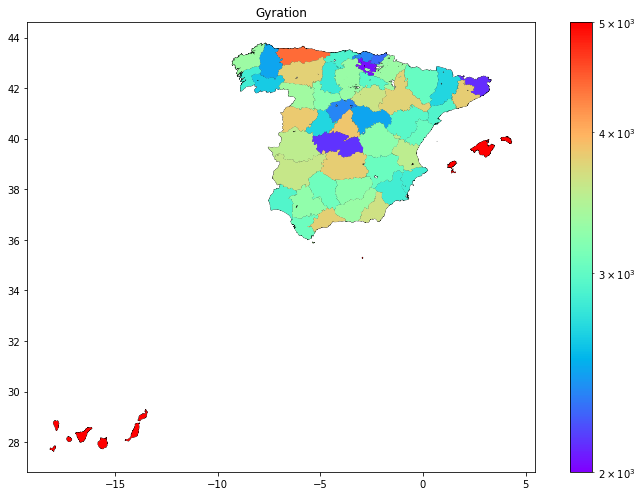

In [50]:

ax = gdf.plot(figsize=(10, 7), facecolor='white', edgecolor='black', linewidth=0.5)
gdf_total = gdf.merge(gdf_points_weekdays[1][['CPRO','gyration']], on=['CPRO'])
gdf_total.plot(ax=ax,
                      column='gyration', cmap='rainbow', legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=2000, vmax=5000))#, legend_kwds={'shrink': 0.75})#,alpha=0.5)
ax.set_title('Gyration')
plt.tight_layout()
plt.savefig('s_gyration_map.pdf', bbox_inches='tight')



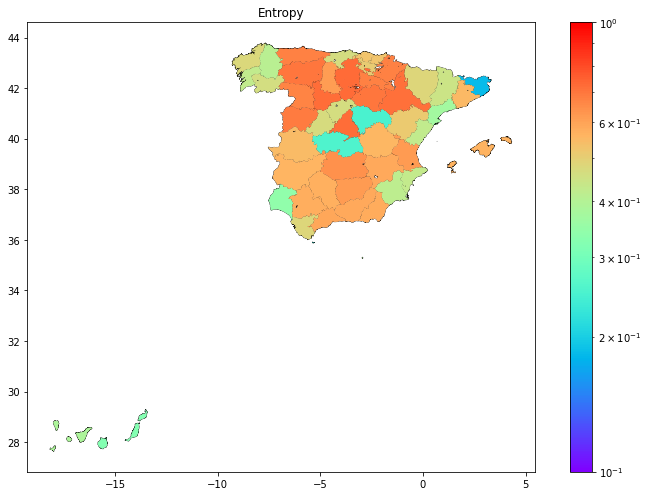

In [69]:
ax = gdf.plot(figsize=(10, 7), facecolor='white', edgecolor='black', linewidth=0.5)
gdf_total = gdf.merge(gdf_points_weekdays[1][['CPRO','signiture_entropy']], on=['CPRO'])
gdf_total.plot(ax=ax,
                      column='signiture_entropy', cmap='rainbow', legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=1))#, legend_kwds={'shrink': 0.75})#,alpha=0.5)
ax.set_title('Entropy')
plt.tight_layout()
plt.savefig('s_entropy_map.pdf', bbox_inches='tight')


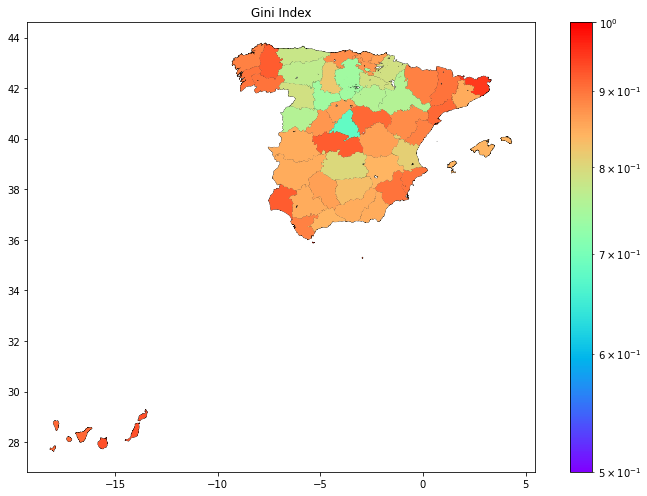

In [71]:
ax = gdf.plot(figsize=(10, 7), facecolor='white', edgecolor='black', linewidth=0.5)
gini_df =  pd.DataFrame(list(gini_weekday[1].items()), columns = ['CPRO','gini'])
gdf_total = gdf.merge(gini_df, on=['CPRO'])
gdf_total.plot(ax=ax,
                      column='gini', cmap='rainbow', legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=0.5, vmax=1))#, legend_kwds={'shrink': 0.75})#,alpha=0.5)
ax.set_title('Gini Index')
plt.tight_layout()
plt.savefig('s_gini_map.pdf', bbox_inches='tight')


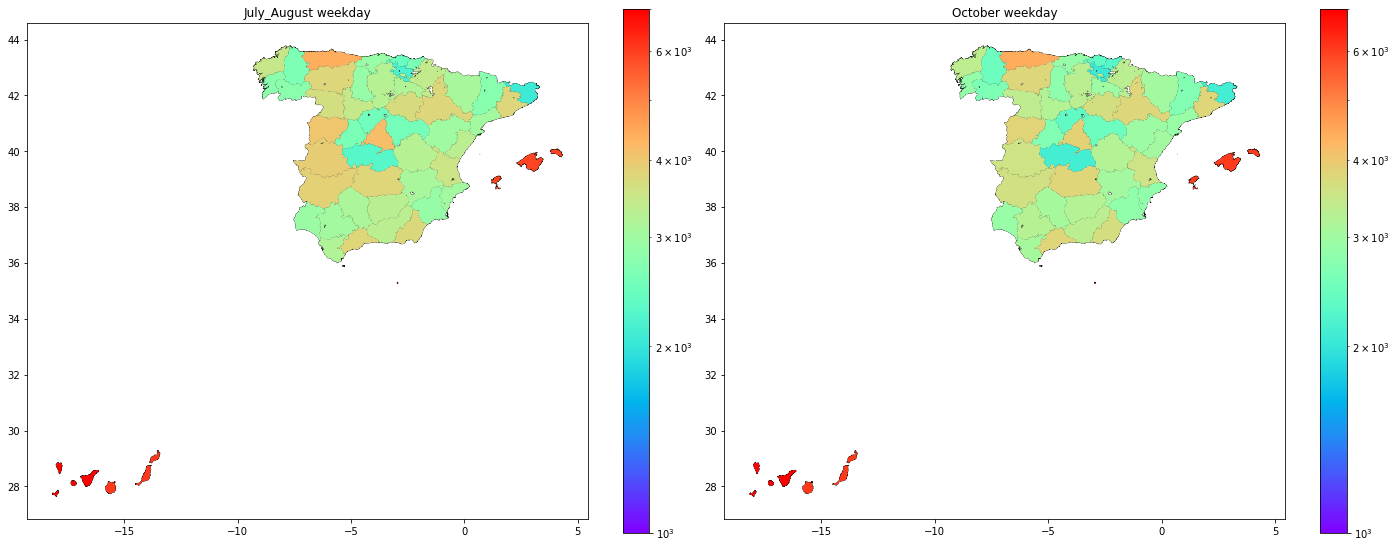

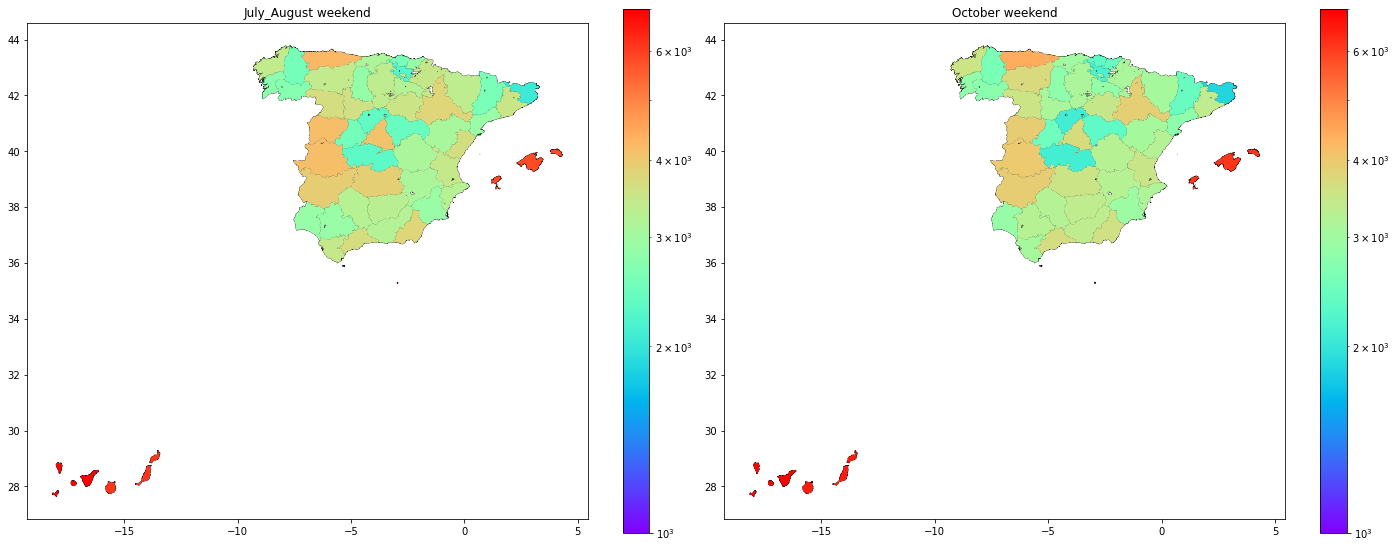

In [64]:
titles = ['July_August weekday','October weekday']

fig, axes = plt.subplots(figsize=(20, 10),ncols=2, nrows=1)
#plt.suptitle("Weekdays", fontsize=16, y=0.88)
for g,title,axe  in zip(gdf_points_weekdays,titles,axes.flat):
    ax = gdf.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gdf_total = gdf.merge(g[['CPRO','gyration']], on=['CPRO'])
    gdf_total.plot(ax=ax,
                          column='gyration', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=1000, vmax=7000), legend_kwds={'shrink': 0.75})#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()
plt.savefig('s_gyration_map_weekday.pdf', bbox_inches='tight')
titles = ['July_August weekend','October weekend']
fig, axes = plt.subplots(figsize=(20, 10),ncols=2, nrows=1)
#plt.suptitle("Weekdays", fontsize=16, y=0.88)

for g,title,axe  in zip(gdf_points_weekend,titles,axes.flat):
    ax = gdf.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gdf_total = gdf.merge(g[['CPRO','gyration']], on=['CPRO'])
    gdf_total.plot(ax=ax,
                          column='gyration', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=1000, vmax=7000), legend_kwds={'shrink': 0.75})#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()
plt.savefig('s_gyration_map_weekend.pdf', bbox_inches='tight')
    

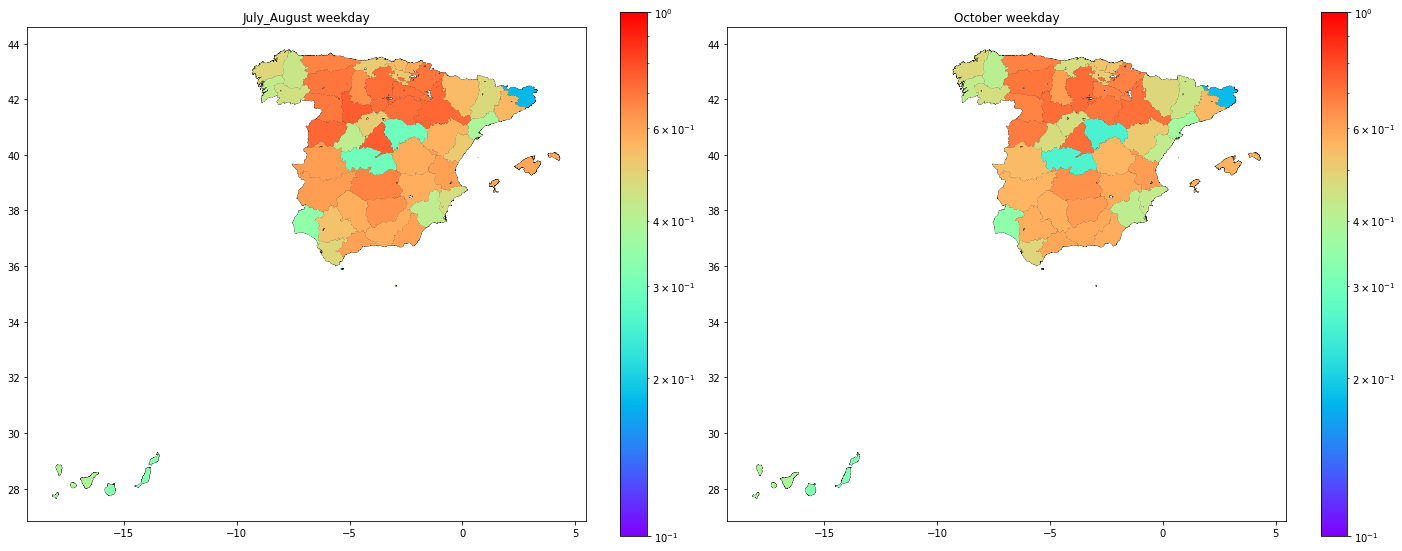

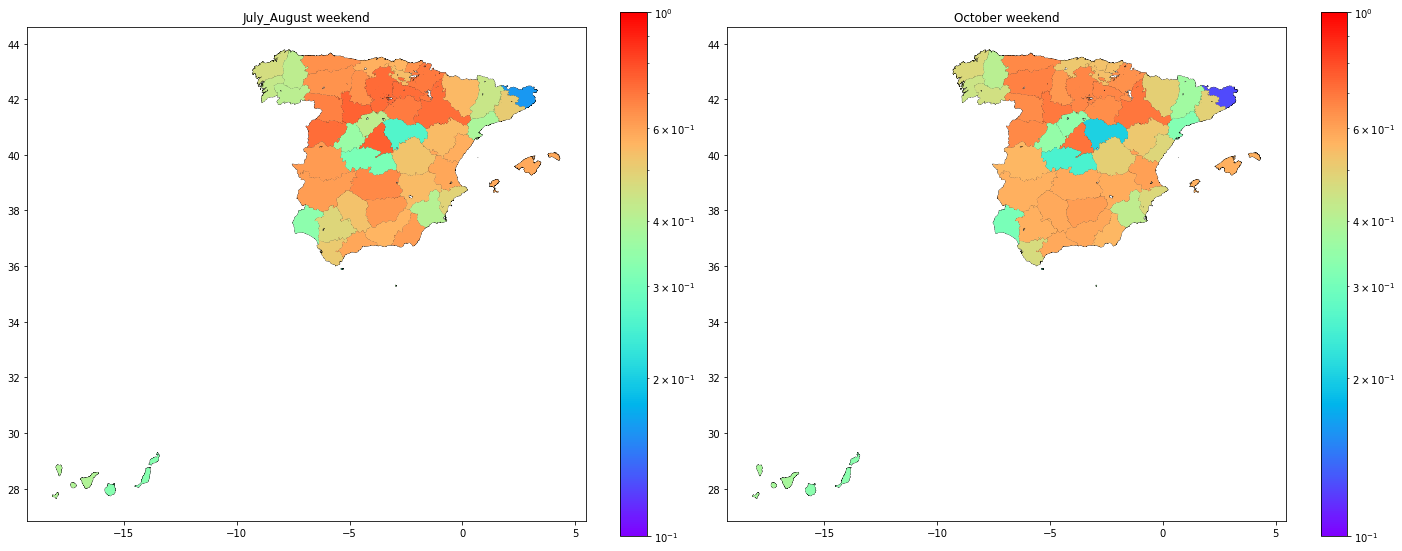

In [65]:
titles = ['July_August weekday','October weekday']

fig, axes = plt.subplots(figsize=(20, 10),ncols=2, nrows=1)
#plt.suptitle("Weekdays", fontsize=16, y=0.88)
for g,title,axe  in zip(gdf_points_weekdays,titles,axes.flat):
    ax = gdf.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gdf_total = gdf.merge(g[['CPRO','signiture_entropy']], on=['CPRO'])
    gdf_total.plot(ax=ax,
                          column='signiture_entropy', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=1), legend_kwds={'shrink': 0.75})#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()
plt.savefig('s_entropy_map_weekday.pdf', bbox_inches='tight')
titles = ['July_August weekend','October weekend']
fig, axes = plt.subplots(figsize=(20, 10),ncols=2, nrows=1)
#plt.suptitle("Weekdays", fontsize=16, y=0.88)

for g,title,axe  in zip(gdf_points_weekend,titles,axes.flat):
    ax = gdf.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gdf_total = gdf.merge(g[['CPRO','signiture_entropy']], on=['CPRO'])
    gdf_total.plot(ax=ax,
                          column='signiture_entropy', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=1), legend_kwds={'shrink': 0.75})#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()
plt.savefig('s_entropy_map_weekend.pdf', bbox_inches='tight')
    

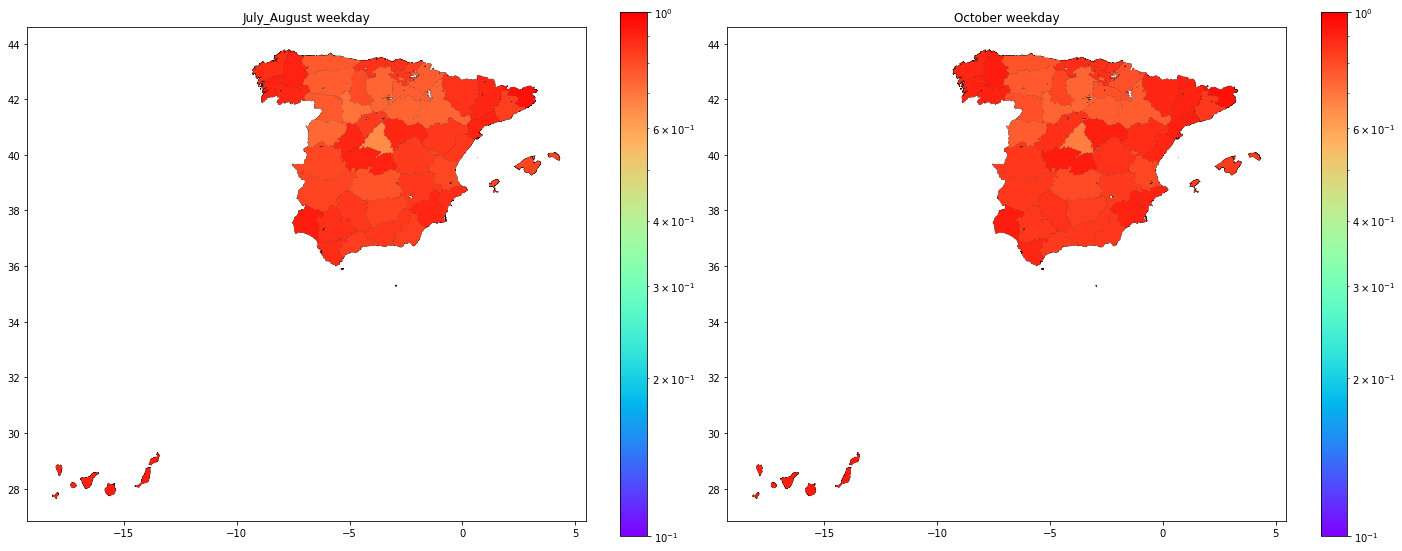

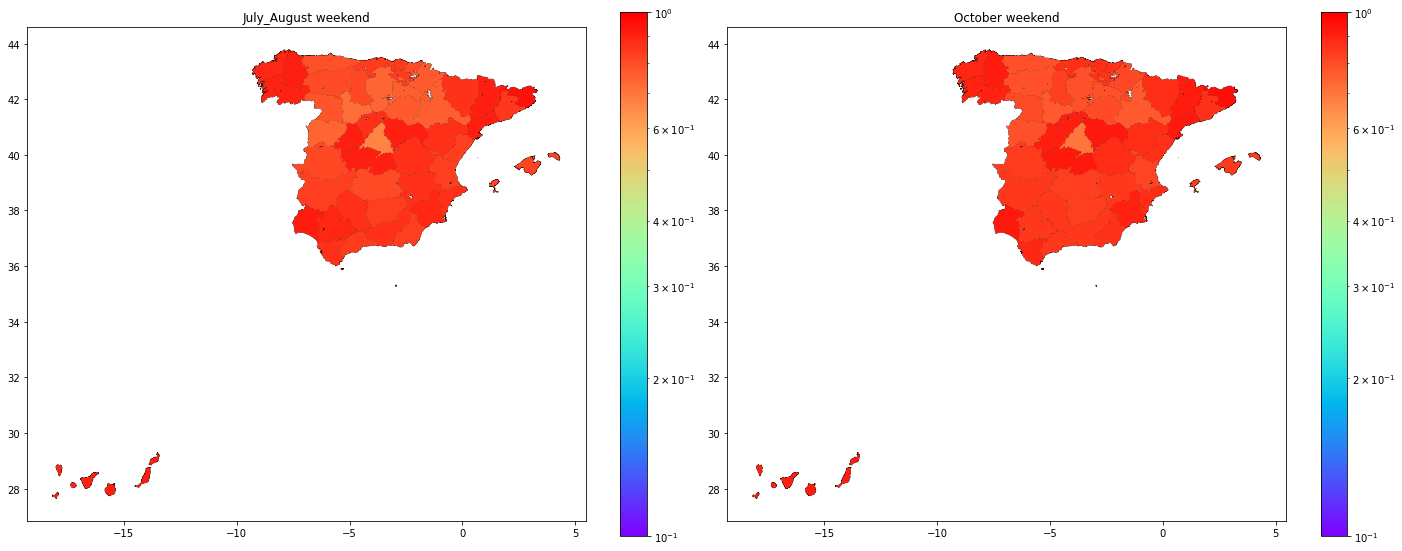

In [66]:
titles = ['July_August weekday','October weekday']

fig, axes = plt.subplots(figsize=(20, 10),ncols=2, nrows=1)
#plt.suptitle("Weekdays", fontsize=16, y=0.88)
for g,title,axe  in zip(gini_weekday,titles,axes.flat):
    ax = gdf.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gini_df =  pd.DataFrame(list(g.items()), columns = ['CPRO','gini'])
    gdf_total = gdf.merge(gini_df, on=['CPRO'])
    gdf_total.plot(ax=ax,
                          column='gini', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=1), legend_kwds={'shrink': 0.75})#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()
plt.savefig('s_gini_map_weekday.pdf', bbox_inches='tight')
titles = ['July_August weekend','October weekend']
fig, axes = plt.subplots(figsize=(20, 10),ncols=2, nrows=1)
#plt.suptitle("Weekdays", fontsize=16, y=0.88)

for g,title,axe  in zip(gini_weekend,titles,axes.flat):
    ax = gdf.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gini_df =  pd.DataFrame(list(g.items()), columns = ['CPRO','gini'])
    gdf_total = gdf.merge(gini_df, on=['CPRO'])
    gdf_total.plot(ax=ax,
                          column='gini', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=1), legend_kwds={'shrink': 0.75})#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()
plt.savefig('s_gini_map_weekend.pdf', bbox_inches='tight')
    

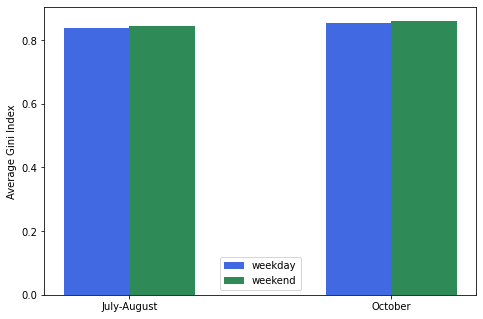

In [80]:
gini_weekday_list = [list(gini_weekday[0].values()),list(gini_weekday[1].values())]
gini_weekend_list = [list(gini_weekend[0].values()),list(gini_weekend[1].values())]
all_means_weekday =  np.mean(gini_weekday_list,axis = 1)
all_means_weekend = np.mean(gini_weekend_list,axis = 1)
tic = ['July-August', 'October']
ind = np.arange(2)
width = 0.25
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(ind, all_means_weekday, width, color='royalblue')
rects2 = ax.bar(ind+width, all_means_weekend, width, color='seagreen')

ax.set_ylabel('Average Gini Index')
ax.set_xticklabels( tic) 
ax.set_xticks(ind + width / 2)
#plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(labels=['weekday', 'weekend'])
plt.tight_layout()
#ax.set_ylim([0.8,0.9])
#plt.grid(True)

plt.savefig('s_ave_gini.pdf', bbox_inches='tight')

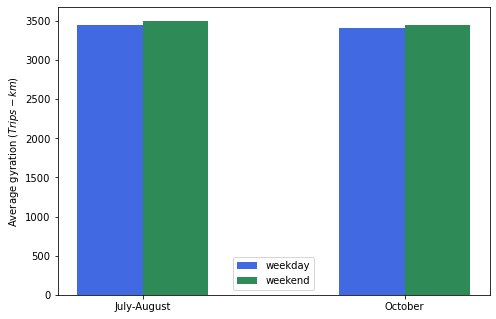

In [51]:
all_means_weekday =  all_gyration_weekday
all_means_weekend = all_gyration_weekend
tic = ['July-August', 'October']
ind = np.arange(2)
width = 0.25
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(ind, all_means_weekday, width, color='royalblue')
rects2 = ax.bar(ind+width, all_means_weekend, width, color='seagreen')

ax.set_ylabel('Average gyration ($Trips-km$)')
ax.set_xticklabels( tic) 
ax.set_xticks(ind + width / 2)
#plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(labels=['weekday', 'weekend'])
plt.tight_layout()
#ax.set_ylim([3300,3600])
#plt.grid(True)

plt.savefig('s_ave_gyration.pdf', bbox_inches='tight')

In [ ]:
all_means_weekday =  all_entropy_weekday
all_means_weekend = all_entropy_weekend
tic = ['July-August', 'October']
ind = np.arange(2)
width =  0.25
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(ind, all_means_weekday, width, color='royalblue')
rects2 = ax.bar(ind+width, all_means_weekend, width, color='seagreen')

ax.set_ylabel('Average normalized entropy')
ax.set_xticklabels( tic) 
ax.set_xticks(ind + width / 2)
#plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(labels=['weekday', 'weekend'])
plt.tight_layout()
#ax.set_ylim([0.5,0.6])
plt.savefig('s_ave_entropy.pdf', bbox_inches='tight')
#plt.grid(True)

In [ ]:
ddnp.mean(results)

In [52]:
def plt_ranked_entropy_gyration(group, gdf_points):    
    plt.figure(figsize=(12, 8))
    
    gini = []
    for i in range(1, 53):
        origen = str(i).zfill(2)
        select_truth = df[df.oz == origen]
        signature_truth = get_destino_distribution(df,origen)
        g3 = round(gini_coefficient(signature_truth.norm_od),2)
        gini.append(g3)
    gdf_points['signiture_gini'] = gini
    
    
    plt.subplot(2, 3, 3)
    gdf_points.sort_values('signiture_gini', ascending=False, inplace=True)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].index, 
                    gdf_points[gdf_points.cluster == cluster].signiture_gini, 
                    color=cluster, marker='o')

    plt.xlabel('Rank')
    plt.ylabel('Gini index')
    plt.tight_layout()


    plt.subplot(2, 3, 1)
    gdf_points.sort_values('gyration', ascending=False, inplace=True)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].index, 
                    gdf_points[gdf_points.cluster == cluster].gyration, 
                    color=cluster, marker='o')

    plt.xlabel('Rank')
    plt.ylabel('Gyration')
    plt.tight_layout()

    
    plt.subplot(2, 3, 2)
    gdf_points.sort_values('signiture_entropy', ascending=False, inplace=True)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].index, 
                    gdf_points[gdf_points.cluster == cluster].signiture_entropy, 
                    color=cluster, marker='o')

    plt.xlabel('Rank')
    plt.ylabel('Entropy')
    plt.tight_layout()
    
    
    plt.subplot(2, 3, 5)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].POP, 
                    gdf_points[gdf_points.cluster == cluster].signiture_entropy, 
                    color=cluster, marker='o')

    plt.ylabel('signiture_entropy')
    plt.xlabel('Population')
    plt.tight_layout()
    
    
    plt.subplot(2, 3, 4)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].POP, 
                    gdf_points[gdf_points.cluster == cluster].gyration, 
                    color=cluster, marker='o')

    plt.ylabel('Gyration')
    plt.xlabel('Population')
    plt.tight_layout()
    
    
    gini = []
    for i in range(1, 53):
        origen = str(i).zfill(2)
        select_truth = df[df.oz == origen]
        signature_truth = get_destino_distribution(df,origen)
        g3 = round(gini_coefficient(signature_truth.norm_od),2)
        gini.append(g3)
    gdf_points['signiture_gini'] = gini
    plt.subplot(2, 3, 6)
    gdf_points.reset_index(inplace=True, drop=True)
    for cluster, count in gdf_points.cluster.value_counts().items():
        plt.scatter(gdf_points[gdf_points.cluster == cluster].POP, 
                    gdf_points[gdf_points.cluster == cluster].signiture_gini, 
                    color=cluster, marker='o')

    plt.xlabel('Population')
    plt.ylabel('Gini index')
    plt.tight_layout()
    plt.savefig('s_cluster_factors.pdf', bbox_inches='tight')

   

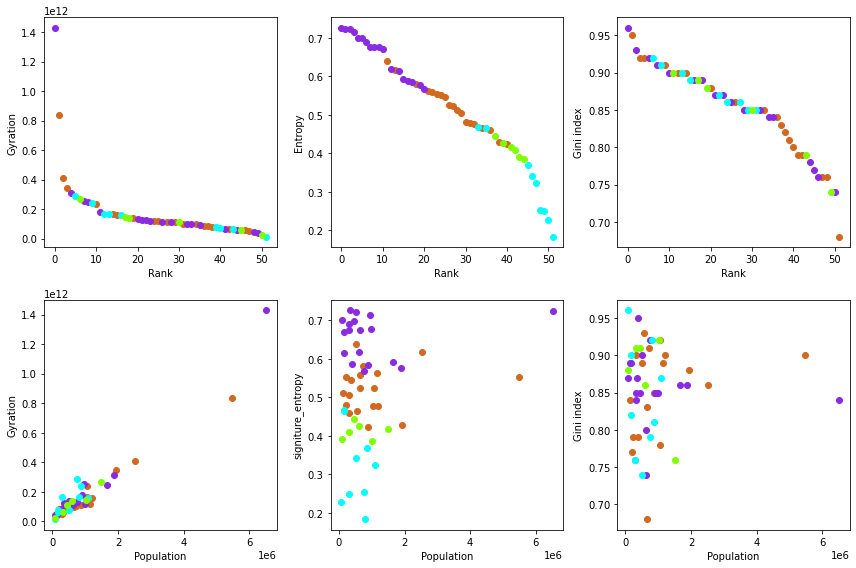

In [53]:
df = october_weekday_df
mobility_network = get_mobility_network(df)
results = get_gyration(mobility_network)
gdf_points = get_gdf_points(results, df)
plt_ranked_entropy_gyration(group, gdf_points)